<a href="https://colab.research.google.com/github/MatheusOrange211/Sirio_Libanes_ICU_Prediction/blob/main/Implementa%C3%A7%C3%A3o_de_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este trabalho foi desenvolvido por **Matheus Naranjo Corrêa**.

# TESTANDO MODELOS PARA PREDIÇÃO DE PACIENTES QUE PRECISARÃO DE UTI

Conforme solicitado pela direção do Hospital Sírio Libanês ao departamento de Tecnologia e Dados, apresentaremos abaixo uma proposta de solução para o seguinte problema:

**PROBLEMA**
> A pandemia da SARS-COVID-19 (popularmente conhecido como coronavírus), vem causando grandes estresses nos sistemas de saúdes globais. Países com alta taxa de desenvolvimento vêm sofrendo com a falta de leitos de Unidade de Terapia Intensiva (UTI) na internação de seus pacientes, levando equipes médicas a terem que aplicar métodos de escolha severos, dando prioridade para os mais idosos e graves. Contudo, tais métodos não auxiliam na resolução do problema dado a alta taxa de contaminação existente, consequência das ondas de infecção que vêm sendo causadas em um efeito de *onda* ao redor do mundo. <br>
Tal problema afeta também países emergentes e subdesenvolvidos, que geralmente já possuem sistemas de saúde superlotados, como no caso do Brasil. Infelizmente a superlotação e a falta de leitos já sobrecarregou sistemas de vários estados, como no caso do estado do Amazonas ([link da matéria](https://g1.globo.com/am/amazonas/noticia/2021/01/14/secretario-de-saude-do-am-fala-que-estado-vive-colapso-do-plano-logistico.ghtml)), onde pacientes não estão mais conseguindo acesso a UTI, assim como não possuem equipamentos básicos para a manutenção de vida, como oxigênio. <br>
Com base nesses acontecimentos e até mesmo na prevenção de sobrecarga do sistema de saúde das redes privadas, o Hospital Sírio-Libanês, referência internacional em saúde, busca prevenir e até mesmo predizer, com base em dados clínicos de seus pacientes, conforme forem sendo admitidos no ambiente hospitalar, a necessidade ou não de internação nas UTIs nas próximas horas. A ideia por trás disso é conseguir desenvolver um modelo de aprendizagem de máquina, conhecido com **Machine Learning**, que consiga auxiliar a junta médica a tomar decisões referentes a necessidade ou não de internação na UTI para aquele paciente, usando as boas práticas de programação e respeitando a Lei Geral da Proteção de dados, conforme indica a lei federal Lei nº 13.709/2018.

Conforme analisado no notebook [Visualizando os Dados](https://github.com/MatheusOrange211/Sirio_Libanes_ICU_Prediction/blob/main/Visualizando_os_dados_Sirio_Libanes.ipynb), realizamos uma breve exploração acerca dos dados fornecidos pela equipe de pesquisa do hospital, buscando entender o que fora nos enviado e como deveriamos ir trabalhando com os dados. Ficou decidido, com base em análises (figura 4 - Internação em UTI pelo tempo de Admissão: Precisou de UTI?), que o melhor janela de admissão para se trabalhar era de até duas horas, uma vez que com ela, poderiamos tentar predizer mais cedo se o paciente necessitaria ou não de internação na UTI.

Nessa segunda parte do projeto, optaremos por testar modelos de Machine Learning que ajudem no nosso problema de **classificação**. Inicialmente realizaremos a importação dos dados, sua limpeza (com funções criadas no notebook de visualização de dados e outras), separação dos dados para treino e teste, o treinamento com alguns algoritmos de classificação e por fim sua validação e implementação.

# IMPORTANDO BIBLIOTECAS

Importaremos as bibliotecas básicas usadas no desenvolvimento de análises e tratamento de dados.

In [ ]:
#Bibliotecas básicas para análises e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------------------------
#biblioteca para medição de tempo de execuções dos modelos
import time 
#---------------------------------------------------------
#biblioteca de Modelos de Machine Learning e ferramentas de auxilio
#---------------------------------------------------------
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
#---------------------------------------------------------
#biblioteca de realização de MÉTRICAS
#---------------------------------------------------------
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from yellowbrick.features.importances import FeatureImportances
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import rocauc
#---------------------------------------------------------
#biblioteca de realização de VALIDAÇÃO
#---------------------------------------------------------
from sklearn.model_selection import cross_validate
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import GridSearchCV

sns.set()
tempo_inicial = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Dados

Os dados fornecidos pela equipe de pesquisa do Hospital Sírio Libanês estão disponíves neste site: [Kaggle - Sírio-libanês](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). Uma explicação dos dados já fora feita no notebook anterior, logo, passaremos para outra parte.


In [ ]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

#FUNÇÕES BÁSICAS - PREPARANDO OS DADOS

Abaixo temos funções que realizarão as limpezas iniciais dos dados

Função usada para nos mostrar um breve resumo do nosso DataFrame (Usada no notebook Visualizando dados)

In [ ]:
def resume_dataframe(dataset  : pd.DataFrame):
  
  data_nan = dataset.isnull().any().any() #retorno os dados Not a Number das colunas
  dataset_types = list (set(dataset.dtypes.values)) #com o set realizo um "filtro" removendo dados repetidos
  print("################ RESUMO BÁSICO ####################\n")
  #shape nos retorna uma tupla com dois valores, sendo um referente a linhas e o outro a coluna, respectivamente.
  print(f"Quantidade de instâncias: {dataset.shape[0]} (linhas)\nQuantidade de Atributos: {dataset.shape[1]} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")
  else:
    print("Não há dados ausentes neste dataset\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")
  print("##################################################\n")

Essa função divide nosso dataframe em 3 pedaços:
* features continuas (contém grande parte das colunas de dados clínicos e NaN)
* features categoricas (as 13 primeiras colunas do nosso DataFrame)
* saida (as duas últimas colunas  - `WINDOW`e `ICU`)

Aplica-se groupby para agrupar cada valor da coluna `PATIENT_VISIT_IDENTIFIER` e nela, aplicar, para as colunas continuas selecionadas, os métodos `bfill`e `fill` para assim preencher os dados faltantesm uma vez que por serem relacionados a saúde, não apresentam, no geral, grandes discrepâncias. Por último, agrupamos tudo novamente e reajustamos as colunas, por fim retornando os dados.

In [ ]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas]\
                          .fillna(method='bfill')\
                          .fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

Como trabalharemos com dados referentes a uma janela de até duas horas após a admissão, buscaremos filtrar e adicionar o valor 1 para pacientes que em algum momento foram para a UTI. Conforme explicado no notebook anterior (caso não tenha visto):<br>
>Essa função é responsável por realizar um filtro do qual busca-se manter valores referentes a janela de até 2 duas horas. Aplicando-se esta função em um groupby, ocorrerá que os dados serão agrupados. Uma vez agrupados, faremos, por meio desta função, uma verificação onde se qualquer uma das linhas conferidas for igual a 1, ou seja, se em um agrupamento do paciente **x** em todos os períodos, se, por exemplo, na janela `0-4`, tivermos o valor de `ICU` == 1  (ou seja, um valor True), será aplicado nessa linha, da primeira janela de admissão (no caso, 0-2), o valor igual a 1 para a coluna ICU. Visualizando:


| WINDOW  |ICU   |   
|---------|------|
| 0-2        | 0  | 
|     2-4    |  0 | 
|       4-6  |   1| 
|       6-12  |   0| 

>Veja como na janela de 4-6 horas, o paciente já foi para UTI. o que esta função fará é por o valor 1 logo na primeira Janela:

| WINDOW  |ICU   |   
|---------|------|
| 0-2        | 1  | 
|     2-4    |  0 | 
|       4-6  |   0| 
|       6-12  |   0|

>E assim, retornaremos apenas a primeira linha.

Essa função agrupa todos os grupos de dados de um paciente e atribui o valor ICU == 1 na janela de até duas horas para assim pordemos trabalhar apenas com pacientes do quadro de até duas horas. Eis o motivo de termos jogado fora dados de pacientes com `ICU = 1` e `WINDOW = 0-2` logo de cara. Se a pessoa já entrou no hospital precisando de UTI, seus dados não servirão para o modelo.

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

Nessa função, o que acontece é que passando nosso dataframe (contendo NaN e strings - não se preocupe quanto a isso), filtramos as colunas e ficamos apenas com as que são numéricas. Depois passamos o método de correlação e damos um .`pipe()` (com ele, a gente pode aplicar funções no DataFrame, por exemplo). Aplicamos um lambda e passamos um `np.tril()`. O que ele fará é retornar os valores maiores que -1 numa matrix de diagonal `k-therizada` (Leia a [documentação](https://numpy.org/doc/stable/reference/generated/numpy.tril.html) para um maior aprofundamento). Criamos as colunas e index e empilhamos as colunas que são geradas durante a correlação. Passando outro `pipe()`, retornamos apenas os valores que são maiores que o parâmetro que passamos na declaração da função. Por último damos um `query()` para realizar um filtro em valores que estão na coluna `level_0` e não em `level_1` .

In [ ]:
def correlated_columns_harrison(dataset, threshold = 0.95):
  df = dataset[dataset.describe().columns]  #fica-se apenas com as colunas que possuem valores numéricos
  return (
      df.corr().pipe(lambda df1: pd.DataFrame(np.tril(df1,k=-1),  
                                              columns = df.columns,
                                              index = df.columns,
                                              )
      ) 
      .stack()
      .rename("pearson")
      .pipe(
          lambda s: s[s.abs() >threshold].reset_index()
      )
      .query("level_0 not in level_1")
  )

Nessa função, iremos criar uma lista com as colunas com valores correlacionados que serão descartadas. Para as duas colunas que ela possui, iremos dropar valores repetidos e adicionar os que sobram a uma lista que é retornada.

In [ ]:
def descartar_colunas_correlacionadas(dataset: pd.DataFrame):
    colunas_com_muita_correlacao = [] #cria-se uma lista vazia 
    for valor in dataset['level_0'].drop_duplicates().values: #dropa-se o nome duplicados de colunsa presentes na coluna level_0
      colunas_com_muita_correlacao.append(valor) #adiciona-se os valores na lista
    for valor in dataset['level_1'].drop_duplicates().values:#dropa-se o nome duplicados de colunsa presentes na coluna level_1
      colunas_com_muita_correlacao.append(valor)  #adiciona-se os valores na lista
    return colunas_com_muita_correlacao

Técnica elaborada por Thiago Gonçalves e Alan Spadinni, conhecida popularmente na literatura alurística de programação como **tecnica Gondinni**, que consiste na criação de correlação de todas as linhas e, com exceção das primeiras 4 e últimas duas colunas do dataframe,  gerar a correlação  e transformação dos valores para absoluto. Depois busca-se selecionar os valores do *triângulo superior* que foram gerados nessa matriz de correlação, todos os valores são transformados para 1s, e depois aplicamos um k = 1 (que gera a divisão dos valores do triângulo superior),, é que aplicamos uma transformação para True nos valores que antes eram 1 , e False para os valores  0s. Dessa forma, quando aplicado o `where`, conseguiremos pegar os valores da matriz superior e assim termos as colunas correlacionas, sem ter a parte do triângulo inferior, que funciona como um espelho. <BR>
Por último, realizando um list comprehenssion, buscaremos todas as colunas maiores que `valor_corte` e adicionamos a `excluir` que será  usada para dropar posteriormente todas as colunas maiores que o valor setado para `valor_corte`.

<img src = "https://static.mundoeducacao.uol.com.br/mundoeducacao/conteudo/matriz-triangular-superior.jpg">

Acima temos um exemplo de uma matriz onde de azul são os valores da diagonal (em azul) que sempre serão iguais a 1, pois são as mesmas colunas refletidas uma na outras , como por exemplo  COLUNA_1 X COLUNA_1 , onde ambas são a mesma coluna, logo é obvio que irão ter correlação perfeita igual a 1. <br>
Em preto, temos o chamado triângulo superior, que é o que desejamos manter, e em vermelho, o chamado triângulo inferior, que será descartado por possuir os mesmos resultados do outro triângulo.

In [ ]:
def remove_corr_var(dados,valor_corte = .95):

  matriz_corr = dados.iloc[:,4:-2].corr().abs()
  matrix_upper = matriz_corr.where(np.triu(np.ones(matriz_corr.shape),k=1).astype(np.bool))
  excluir  = [ coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

  return dados.drop(excluir,axis=1)

Essa função irá executar os modelos:
* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* KNeighborsClassifier
* GaussianNB
* SVC
* RandomForestClassifier
* XGBClassifier

Passamos apenas o dataset que deverá ser particionado em treino e teste, depois com um laço de repetição, iremos obter os resultados de cada modelo para determinado conjunto de dados passados. A ideia é apenas ter uma visão inicial de como os dados estão funcionando, se logo de cara, já estão treinando bem, por isso não é passado parâmetros mais específicos para cada modelo, o que pode ocasionar a saída de **WARNINGS**. Contudo, pelos motivos explicados, isso é previsto. Por fim, temos a saída de uma lista com os valores AUC, desvio padrão (STD), e o tempo de execução.

In [ ]:
def rodar_varios_modelos(dataset):
  
  x_columns = dataset.columns
  x_columns = x_columns.drop(["PATIENT_VISIT_IDENTIFIER"])
  y = dataset["ICU"]
  x = dataset[x_columns].drop(["ICU"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  results = []
  np.random.seed(415645)
  for model in [DummyClassifier,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,GaussianNB,
                SVC,RandomForestClassifier,XGBClassifier]:

                start_time  = time.time()

                model_used = model()

                kfold = StratifiedKFold(n_splits=5,shuffle=True)
                val_score = model_selection.cross_val_score(model_used,x,y,scoring="roc_auc",
                                                            cv = kfold)
                
                results.append(f"{model.__name__:22} AUC:\
                {val_score.mean():.3f} STD: {val_score.std():.2f}     Tempo execução: {time.time() - start_time} seconds")

  return results

Esta função recebe um conjunto de dados, e dela realiza a manipulação de dividir os dados em treinos e testes. Primeriramente agrupamos os nomes de todas as colunas do dataset, para depois dividir em um y que recebe apenas os valores que desejamos ter como resposta, e no x, o conjunto de dados que usaremos para testes e treinamentos. Remove-se as colunas que podem conter vazamento de informações e com valores que podem prejudicar o modelo. Por fim, aplica-se o  `train_test_split` que irá realizar cortes no nosso conjunto de dados e irá realizar essas divisões em X treino e testes  e Y treino e testes.

In [ ]:
def criar_treino_teste(dataset):
  np.random.seed(727356)
  x_columns = dataset.columns
  y = dataset["ICU"]
  x = dataset[x_columns].drop(["ICU","PATIENT_VISIT_IDENTIFIER"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  return  x_train, x_test, y_train, y_test

Essa função realiza o processo de split dos daddos, realizando primeiramente um embaralhamento nos dados para que possamos ter uma aleatoriedade de dados que simule um processo real. Depois realizamos as divisões no conjunto de dados para teste e treino. Com o auxilio do `RepeatedStratifiedKFold` iremos embaralhar, fatiar e repetir este processos $k$ numero de vezes que forem adequadas. <BR>
Iremos ainda aplicar o `cross_validate` para realizar o cruzamento destes dados. Ele irá seus resultados no formato de dicionário, do qual printaremos uma média tanto para o `score_test`, `train_score`, que são as respectivas pontuações de teste e treino, assim como o desvio padrão gerado pelo `test_score`

In [ ]:
def roda_modelo_cv(modelo, dados,n_splits,n_repeats):


  np.random.seed(434876)
  #como não temos a opção shuffle aqui,
  #está se torna uma forma de embaralhar dados
  dados = dados.sample(frac=1).reset_index(drop=True) #reseta index gerados


  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv,scoring='roc_auc',return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  
  
  print(f"AUC: {auc_medio} -  {auc_medio_treino}")
  return auc_medio, auc_medio_treino

Essa função irá nos retornar duas informações importantes!<br>
A primeira, que é o valor AUC gerado pelo modelo que passamos e o outro, será o Classification Report que contém informações importantes a cerca de métricas como Precisão, Recall e F1-Score, para as classes que serão classificadas. Primeiro, passamos apenas o modelo e os conjunto de dados, depois, eles serão tratados, criando um **y** apenas com os dados de "resposta". Criamos as variáveis de treino e teste, depois as treinamos. Depois predizemos. Passamos um método de predição probabilística, que será fundamental para que se consiga medir o valor AUC daquele modelo. Por fim, printamos, além da pontuação AUC, as métricas das classes, passando os dados reais (y_test) e a nossa predição.

In [ ]:
def roda_modelo(modelo, dados):
  np.random.seed(154145)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  
  modelo.fit(x_train, y_train)

  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)
  
  auc = roc_auc_score(y_test,prob_predic[:,1])
  print(f"AUC: {auc}")
  print("\nClassification Report")
  print(classification_report(y_test,predicao))


A função plota um gráfico com as métricas roc_auc, passando o modelo de Machine Learning, o dataset e o nome do dataset usado para ser plotado posteriormente.

In [ ]:
def plotar_roc_auc(modelo,dados,name_dataset):
  np.random.seed(165488)
  
  
  # x_columns = dados.columns
  # y = dados["ICU"]
  # x = dados[x_columns].drop(["ICU"], axis=1)
  # x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  #treinamos
  modelo.fit(x_train, y_train)
  #predizemos 
  predicao = modelo.predict(x_test)
  #plotamos a figura na qual ROCAUC irá realizar os calculos, pedindo apenas que
  #passemos o modelo
  fig, aux = plt.subplots(figsize=(9,9))
  roc_viz = rocauc.ROCAUC(modelo)
  #realizamos também os calculos de pontuação que são apresentados na legenda do gráfico
  roc_viz.score(x_test,y_test)
  plt.legend()
  plt.title(f"Curva ROC para {name_dataset} - MODELO {modelo.__class__.__name__}")
  plt.show()

Busca-se descobrir a acurácia de certo modelo para certo conjunto de dados. Para evitar a repetição de código desnecessária, cria-se essa função.

In [ ]:
def saber_acuracia (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #separa-se os dados aqui para evitar erros externos.
  print(f"A acurácia do Modelo Logístico para dados_limpos é de : {(accuracy_score(y_test, predicao_dados))*100 :.2f} %")

Criamos uma matriz de confusão que mostra o desempenho de acertos e erros de cada modelo para as classes de dados. O gráfico é gerado pelo próprio `plot_confusion_matrix`.

In [ ]:
def plotar_confusion_matrix (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #realizamos a divisão e treinamento dos dados para evitar qualquer erro externo

  #então passamos o modelo usado, os dados de teste predizidos, os dados reais e
  #as respectivas labels para 0 = não internar e 1 = Internar
  figura = plot_confusion_matrix(modelo,x_test,y_test,display_labels=['Não Internar','Internar'])

Mostra quais colunas estão sendo "mais importantes" para aquele modelo, por meio de uma pontuação.

In [ ]:
def plotar_FeatureImportances (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #depois de separado os dados de treino e teste e depois dos treinamentos e predições
  #criamos um grafico
  fig,ax = plt.subplots(figsize=(15,35))
  #passamos o modelo que irá ser usados para detectar as colunas "mais importantes"
  fi_viz = FeatureImportances(modelo)
  #realizamos um teste com as configurações instanciadas na variável anterior
  fi_viz.fit(x_test,y_test)
  #mostramos
  fi_viz.poof()

A função gera a chamada curva de validação, buscando descobrir como determinado hiperparâmetro númerico se comporta conforme passamos um laço de repetição e plotamos ao longo de cada iteração.

><font color='red'> **OBSERVAÇÃO**: **OS VALORES DO EIXO-Y NÃO INICIAM NO VALOR 0 , POIS OS GRÁFICOS SÃO GERADOS AUTOMATICAMENTE E,PRESSUPÕE-SE QUE MOSTRAR A PARTIR DE UM VALOR IGUAL A 0.6 OU 60% (COMO NO NOSSO CASO)  TORNA A VISUALIZAÇÃO MELHOR PARA OS RESULTADOS. ISSO SE REFLETIRÁ EM TODOS OS PLOTS DE CURVA DE VALIDAÇÃO E CURVA DE APRENDIZAGEM** </font>

In [ ]:
def curva_validacao(modelo,dados,n_range_max,param):
  np.random.seed(35468)
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)

  #separado os dados, iremos plotar uma gráfico
  fig,ax = plt.subplots(figsize=(12,6))
  #validationcurve cria uma espécie de laço for onde o modelo é treinado com 
  #certa configuração e com o parâmetro que passamos sendo modificados n_range_max
  # vezes, começando de 1. 
  vc_viz =  ValidationCurve(modelo,param_name= param,
                            param_range = np.arange(1,n_range_max),
                            cv = 10,
                            n_jobs = -1)
  #n_jobs  = -1 significa que iremos usar todas as threads do processador para 
  #conseguir eficiencia
  vc_viz.fit(x_train,y_train)
  vc_viz.poof()

A função primeiramente irá gerar os dados de treino e de teste, para que depois, possamos plotar uma curva de aprendizagem comparativa entre a validação cruzada e os dados de treino. Será plotado um gráfico de linhas mostrando como o modelo se comporta com uma certa quantidade de dados.

In [ ]:
def curva_aprendizagem(modelo,dados):
  np.random.seed(43545)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
  
  # depois de tratar, e separar os dados, criamos um gráfico 
  fig,ax = plt.subplots(figsize=(12,6))
  #Passamos o modelo e o valor cv referente a frequencia de repetição da validação
  #cruzada estimada para 10
  lc3_viz =  LearningCurve(modelo,cv = 10)
  #treinamos e plotamos
  lc3_viz.fit(x_train,y_train)
  lc3_viz.poof()

Esta função utilizará a o `GridSearchCV` para ir treinando um dicionário de valores que queremos testar e no fim, retornará o tempo que levou para executar e também o melhor modelo para o nosso conjunto de dados passado.

In [ ]:
def buscar_melhor_parametro(dados_usados,modelo_usado,param_grid):
  #inicia o time de tempo de execução
  start_time = time.time()
  #a função retorna os dados treinados e de teste já separados e tratados
  x_train,x_test,y_train,y_test = criar_treino_teste(dados_usados)
  #essa função aplica então a procura pelo melhor modelo para esse conjunto de 
  #dados. Passamos o modelo que usaremos, os parâmetros que queremos verificar neste
  #modelo, além da pontuação que usamos para medir a qualidade gerada
  grid_search = GridSearchCV(modelo_usado, param_grid, scoring="roc_auc")
  #começaremos a treinar os modelos para os valores de treino
  grid_search.fit(x_train, y_train)


  #o modelo então buscará aquele que melhor desempenhar
  melhor_modelo = grid_search.best_estimator_ 
  #ele buscará então os melhores parâmetros e a melhor pontuação
  grid_search.best_params_, grid_search.best_score_
  #printamos então o tempo de execução, a pontuação dos dados de treino, teste
  # e os melhores parâmetros do modelo.
  
  print( f"Tempo execução: {time.time() - start_time} segundos\n")
  print(f"TREINO :{grid_search.score(x_train,y_train):.2f} \nTESTE :{grid_search.score(x_test,y_test):.2f} ")
  print(f"\n\n{melhor_modelo}")

# PREPARANDO O DATAFRAME

Antes de aplicar os modelos e ver qual possui melhor custo benefício, vamos preparar nosso dataframe

Cria-se a variável que armazanerá os dados formatados e previamente, limpos. Aqui, iremos também, realizar uma query por todas as colunas as linhas que possuem `WINDOW=='0-2' and ICU==1`, pois essas, serão eliminadas de imediado, dados que seus dados não nos servem. Realizamos um dropna para remover dados NaN restantes, caso haja.

In [ ]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

Possuímos dados Categóricos em nosso conjunto de dados. Logo, ainda precisamos limpar mais, antes de começarmos a aplicar algum modelo. As colunas `AGE_PERCENTIL`e `WINDOW` possuem informações do tipo **String** que precisam ser categorizadas de forma a não gerar uma discrepância alta de valores e assim influenciar de forma errada nosso modelo. Digo isso pois, a aplicação de um `.astype("category").cat.codes` resultaria em valores iguais a 5,3, 2 e assim em diante, e nossos estão normalizados. Buscando resolver isso, aplico um `pd.get_dummies` para que seja criada uma coluna para cada valor, sendo preenchido de 0s e 1s. Observe também que antes de realizar isso, na linha acima, em `apply`, aplico a função `prepare window`. Ficamos então apenas com o quadro de até duas horas após a admissão.

In [ ]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos) 
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073

Antes de iniciar a aplicação dos modelos de Machine Learning, vejamos o que temos nos dados agora:

In [ ]:
resume_dataframe(dados_limpos)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 240 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('int64'), dtype('float64'), dtype('uint8')]

##################################################



Possuimos então 240 colunas no total. Entretanto talvez não seja necessário o uso de todas essas colunas, dado que muitas colunas podem vir a atrapalhar as predições. Criarei dois dataframes, onde ambos buscarão excluir dados com alta correlação, mas onde ambos realizam tal tarefa de forma diferente. 

### 2 MÉTODOS PARA EXCLUIR DADOS CORRELACIONADOS

**Excluindo-se dados correlacionados com a técnica de Matt Harisson**

In [ ]:
#cria-se um dataframe com 3 colunas(duas onde os valores são o nome de colunas e a terceira com os valores de correlação > .95)
dados_correlacionados = correlated_columns_harrison(dados_limpos,.95)

#filtra-se de ambas as colunas que possuem nomes aqueles que não se repetem, gerando uma lista
excluir = descartar_colunas_correlacionadas(dados_correlacionados)

#descarta-se as colunas com alta correlação
dados_limpos_sem_corr_tipo_1 = dados_limpos.drop(excluir,axis=1)

In [ ]:
resume_dataframe(dados_limpos_sem_corr_tipo_1)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 64 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('int64'), dtype('float64'), dtype('uint8')]

##################################################



**Excluindo-se dados correlacionados com a técnica de Thiago Gonçalves e Alan Spadinni: técnica Gondinni**

In [ ]:
dados_limpos_sem_corr_tipo_2 = remove_corr_var(dados_limpos)

In [ ]:
resume_dataframe(dados_limpos_sem_corr_tipo_2)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 109 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('int64'), dtype('float64'), dtype('uint8')]

##################################################



Nota-se que em um método, temos 64 colunas, no outro, 109. 


### DADOS A SEREM TREINADOS INICIALMENTE

>Por fim, temos três variáveis referentes aos dados de pacientes:

* `DADOS_LIMPOS` = **POSSUE TODAS AS COLUNAS (240)**
* `DADOS_LIMPOS_SEM_CORR_TIPO_1` = **POSSUE COLUNAS SEM ALTA CORRELAÇÃO COM BASE NA TÉCNICA DE MATT HARISSON (64)**
* `DADOS_LIMPOS_SEM_CORR_TIPO_2` = **POSSUE COLUNAS SEM ALTA CORRELAÇÃO COM BASE NA TÉCNICA GONDINNI (109)**

>Todas as variáveis estão sem dados Not a Number (NaN) e serão usadas em todos os modelos para que possamos ver qual se desempenhará melhor.

# IMPLEMENTAÇÃO DE MODELOS DE APRENDIZAGEM DE MÁQUINA

Nosso projeto consiste na classificação de pacientes que devem ir para UTI ou não, com base em uma série de dados referentes a seus exames e sinais vitais. Para isso, nada melhor do que aplicar técnicas de aprendizagem de máquinas voltadas para classificação. Por conceito temos:

>Os modelos de ML para problemas de classificação binária preveem um resultado binário (uma de duas classes possíveis).<br> ([link para referência](https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/types-of-ml-models.html))

No nosso caso, utilizarei os seguintes modelos:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* KNeighborsClassifier
* GaussianNB
* SVC
* RandomForestClassifier
* XGBClassifier

Contudo, apesar de uma breve explicação sobre cada um, não trabalharemos com todos. Iremos apenas inicialmente rodá-los e dependendo do desempenho, ficaremos com 4 ou 5 modelos para trabalhar. Logo, algumas coisas a se levar em conta:

* Sua precisão, recall e acucácia;
* Para que o modelo possa ser usado, ele deve possuir um custo-benefício bom o suficiente para entrar em produção. De nada serve um modelo 100% bom em classificar, mas que leva 2 horas para fazer isso (levando em conta que os dados crescerão com o tempo).



Testando inicialmente os conjunto de dados com os modelos, mas sem especificar os parâmetros, temos:<br>
***
***
**OBSERVAÇÃO**: desconsiderar avisos de warning
***
***

Rodando primeiramente para `dados_limpos`

In [ ]:
resultados_dados_limpos = rodar_varios_modelos(dados_limpos)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarn

Rodando para `dados_limpos_sem_corr_tipo_1`


In [ ]:
resultados_sem_corr_tipo_1 = rodar_varios_modelos(dados_limpos_sem_corr_tipo_1)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarn

rodando em `dados_limpos_sem_corr_tipo_2`

In [ ]:
resultados_sem_corr_tipo_2 =rodar_varios_modelos(dados_limpos_sem_corr_tipo_2)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarn

#### Resultados iniciais para vários modelos e quais serão usados

# EXPLICAR PARÂMETROS AUC STD E TEMPO DE EXECUÇÃO

Abaixo, iremos conferir melhor a questão de desempenho dos modelos que foram treinados. Todos eles servem para classificação, contudo, podem não ser o melhor para o que é proposto no nosso projeto. Tendo isso em mente, algumas métricas iniciais são levadas em conta e que podem fazer a diferença.
<br>
O AUC - Area Under Curve ou área sobre a curva, mede a capacidade do modelo de prever uma pontuação maior de exemplos positivos em comparação com os exemplos negativos. Como ela não depende do corte da pontuação, você poderá ter uma ideia da precisão da previsão do modelo a partir da métrica AUC, sem escolher um limite.
<br>
Já o STD ou o desvio padrão é uma medida que indica a dispersão dos dados dentro de uma amostra com relação à média. Assim, quando se calcula o desvio padrão juntamente com a média de diferentes grupos, obtém-se mais informações para avaliar e diferenciar seus comportamentos.
<br>
Por fim, o tempo de execução servirá para termos uma noção de quanto tempo está sendo levado para divisão de dados, treino, predição e teste em cada modelo. Isso é de fundamental importância e será determinante mais pra frente, quando nossa base de dados se tornar maior e mais complexa. Afinal, do que adianta um modelo 100% preciso, mas que demora inúmeras horas para auxiliar em algo tão emergencial como saber se um paciente necessita ou não de UTI?


Vejamos então como o filtro de dados realizados, auxiliarão no resultado final dos modelos.

In [ ]:
resultados_dados_limpos

['DummyClassifier        AUC:                0.502 STD: 0.06     Tempo execução: 0.027831077575683594 seconds',
 'LogisticRegression     AUC:                0.740 STD: 0.03     Tempo execução: 0.3126702308654785 seconds',
 'DecisionTreeClassifier AUC:                0.619 STD: 0.03     Tempo execução: 0.15085601806640625 seconds',
 'KNeighborsClassifier   AUC:                0.655 STD: 0.06     Tempo execução: 0.10971927642822266 seconds',
 'GaussianNB             AUC:                0.744 STD: 0.03     Tempo execução: 0.03624272346496582 seconds',
 'SVC                    AUC:                0.769 STD: 0.08     Tempo execução: 0.20143914222717285 seconds',
 'RandomForestClassifier AUC:                0.788 STD: 0.01     Tempo execução: 1.066347360610962 seconds',
 'XGBClassifier          AUC:                0.779 STD: 0.02     Tempo execução: 1.3477206230163574 seconds']

In [ ]:
resultados_sem_corr_tipo_1

['DummyClassifier        AUC:                0.502 STD: 0.06     Tempo execução: 0.016945600509643555 seconds',
 'LogisticRegression     AUC:                0.712 STD: 0.09     Tempo execução: 0.19057917594909668 seconds',
 'DecisionTreeClassifier AUC:                0.589 STD: 0.03     Tempo execução: 0.042218923568725586 seconds',
 'KNeighborsClassifier   AUC:                0.670 STD: 0.04     Tempo execução: 0.06554746627807617 seconds',
 'GaussianNB             AUC:                0.690 STD: 0.04     Tempo execução: 0.028432369232177734 seconds',
 'SVC                    AUC:                0.694 STD: 0.06     Tempo execução: 0.08236527442932129 seconds',
 'RandomForestClassifier AUC:                0.682 STD: 0.05     Tempo execução: 0.7974598407745361 seconds',
 'XGBClassifier          AUC:                0.731 STD: 0.04     Tempo execução: 0.3098764419555664 seconds']

In [ ]:
resultados_sem_corr_tipo_2

['DummyClassifier        AUC:                0.502 STD: 0.06     Tempo execução: 0.021927356719970703 seconds',
 'LogisticRegression     AUC:                0.750 STD: 0.04     Tempo execução: 0.23187708854675293 seconds',
 'DecisionTreeClassifier AUC:                0.611 STD: 0.02     Tempo execução: 0.08295416831970215 seconds',
 'KNeighborsClassifier   AUC:                0.698 STD: 0.06     Tempo execução: 0.0687103271484375 seconds',
 'GaussianNB             AUC:                0.731 STD: 0.03     Tempo execução: 0.028757572174072266 seconds',
 'SVC                    AUC:                0.754 STD: 0.09     Tempo execução: 0.11360883712768555 seconds',
 'RandomForestClassifier AUC:                0.793 STD: 0.03     Tempo execução: 0.9162993431091309 seconds',
 'XGBClassifier          AUC:                0.776 STD: 0.02     Tempo execução: 0.5834300518035889 seconds']

Ao que tudo indica, os modelos performaram melhor em:
* `dados_limpos` (onde permaneceram a maior parte das colunas)
* `dados_limpos_sem_corr_tipo_2` (Segundo o método GONDINNI)

Além disso, no geral, os modelos que obtiveram bons resultados :
* Logistic Regression
* Random Forest Classifier
* XGBClassifier


Portanto, analisaremos estes modelos mais a fundo, apresentando uma breve explicação a cerca de seu funcionamento, e realizaremos alguns testes referentes a acerto, tempo de execução e processamento.

# 📊📖 EXPLICANDO MODELOS ESCOLHIDOS

Dado os modelos escolhidos, explicarei inicialmente um pouco de cada um, buscando não extender demais o tema para não perdermos o foco. Logo depois, iremos escolher quais resolvem melhor nosso problema, testar com tais modelos e determinar quais se saíram melhores, para no final, decidirmos.

## 📕 Logistic Regression

Antes de explicar a **logistic regression** ou **regressão logistica**, é necessário compreender um pouco sobre regressão Linear. A **regressão Linear** é o processo de traçar uma reta através dos dados que são gerados através de um diagrama de dispersão. A partir daí, buscamos traçar uma equação que gere uma reta que nos mostre a relação existente nos dados.<br>
A equação usada para buscar tal reta é :
\begin{equation}
\hat y = \alpha + \beta x + e
\end{equation}

onde:
* **x** : Variável independente que busca explicar y
* **y**: Variável dependente a ser prevista
* $\alpha$ e $\beta$ : são parâmetros de distribuição
* $e$ : erros de medida

Abaixo, temos um exemplo de regressão linear. Os pontos em vermelho representam nossos dados dispersos ao longo de um plano cartesiano em $R^2$ e em azul, temos uma reta que é gerada a partir de uma função que nós criamos derivada da equação de regressão linear.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/LinearRegression.svg/1200px-LinearRegression.svg.png" width=480>


Assim, supondo que nosso objetivo fosse, a partir de uma base de dados, classificar a qualidade dos estudos de alunos de acordo com as horas de estudo e suas respectivas notas, poderiamos aplicar a regressão linear facilmente e assim buscar a probabilidade do aluno tirar uma nota $y$ baseado nas $x$ horas que ficou estudando.

Contudo, e se buscássemos saber qual a probabilidade de uma pessoa comprar um produto. Nossa variável resposta seria *comprar* e *não-comprar*. Com base em algumas variáveis como idade, salario e afins, como poderiamos classificar as pessoas que comprariam ou não o nosso produto, ou no caso do projeto, quais irão ou não precisar de UTI. Esse é um caso em que a regressão linear não nos ajudaria.

Nesse caso, podemos então, aplicar uma regressão logistica, que apesar do nome, é na verdade um modelo linear de classificação. Neste modelo, as probabilidades que descrevem os possíveis resultados de um único ensaio são modeladas com o auxílio de uma função logística.<br>
Equação da função logística:
\begin{equation}
  f(x)={\frac {L}{1+e^{-k(x-x_{0})}}}\end{equation}

onde:
* $x_0$: valor do ponto médio do sigmoide;
* $L$ : valor máximo da curva;
* $K$: a taxa de crescimento logístico ou a inclinação da curva.

Visualmente a função logística é assim:<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png">

A regressão logística é um recurso que nos permite estimar
a probabilidade associada à ocorrência de determinado
evento em face de um conjunto de variáveis explanatórias.
Como característica, Busca estimar a probabilidade da variável
dependente assumir um determinado valor em
função dos conhecidos de outras variáveis e os resultados da análise ficam contidos no
intervalo de zero a um.
<br>
Na regressão logística, a probabilidade de ocorrência de um
evento pode ser estimada diretamente. No caso da variável
dependente
Y assumir apenas dois possíveis estados (1 ou 0)
e
haver um conjunto de
p variáveis independentes
X1 , X2 , ... , Xp
, o
modelo de regressão logística pode ser escrito da seguinte forma:

\begin{equation}
P\big(Y = 1 ) = \frac{1}{1 + e^{-g(x)}}
\end{equation}

onde: 
\begin{equation}
g\big(x\big) = B_0 + B_1X_1 + ... B_pX_p
\end{equation}

Abaixo temos um exemplo mostrando a dirença entre regressão linear e regressão logística:

<img src= "https://estatsite.com.br/wp-content/uploads/2018/08/1-3.jpg" width=690>

Os pontos brancos em y=1 e y=0 podem ser interpretados como comprar e não-comprar, ou no nosso caso, precisa de UTI = 0, não precisa de UTI = 1. Veja como  a regressão logistica irá conseguir pegar um maior conjunto de dados.

## 📕 Random Forest Classifier

Random Forest ou Florestas aleatórias, é um algoritmo de aprendizagem supervisionado. Pode ser usado tanto para classificação quanto para regressão. É também o algoritmo mais flexível e fácil de usar. Uma floresta é composta por árvores. Diz-se que quanto mais árvores ela tem, mais robusta é uma floresta. Florestas aleatórias criam árvores de decisão em amostras de dados selecionadas aleatoriamente, obtém previsão de cada árvore e seleciona a melhor solução por meio de votação. Ele também fornece um indicador muito bom da importância do recurso. <br>

Como vantagens temos:

* Florestas aleatórias são consideradas como um método altamente preciso e robusto devido ao número de árvores de decisão que participam do processo.
* Não sofre do problema de excesso de adaptação. A principal razão é que leva a média de todas as previsões, o que cancela os vieses.
* O algoritmo pode ser usado tanto em problemas de classificação quanto de regressão.
* Florestas aleatórias também podem lidar com valores perdidos. Existem duas maneiras de lidar com isso: usar valores medianos para substituir variáveis contínuas e calcular a média ponderada de proximidade dos valores perdidos.
* Você pode obter a importância relativa do recurso, o que ajuda na seleção dos recursos mais contribuintes para o classificador.



## 📕 XGBoost Classifier

XGBoost é uma biblioteca de aumento de gradiente distribuído otimizada projetada para ser altamente eficiente, flexível e portátil. Ele implementa algoritmos de aprendizagem de máquina sob a estrutura Gradient Boosting. O XGBoost fornece um reforço paralelo de árvores (também conhecido como GBDT, GBM) que resolvem muitos problemas de ciência de dados de forma rápida e precisa. <br>
O mesmo código é executado nos principais ambientes distribuídos (Hadoop, SGE, MPI) e pode resolver problemas além de bilhões de exemplos.
<Br>


Para um maior conhecimento técnico sobre a biblioteca, com as explicações matemáticas aprofundadas feitas pelos próprios autores, consulte o [documento oficial](https://arxiv.org/pdf/1603.02754.pdf).

# 🤹‍♂️ TESTANDO OS MODELOS INDIVIDUALMENTE

Chegou o momento de testarmos individualmente cada modelo, aplicando parâmetros específicos e buscando extrair o máximo que der de cada um, com o objetivo de aumentar os acertos, usando as duas base de dados:
* `dados_limpos`
* `dados_limpos_sem_corr_tipo_2` 

Realizaremos os seguintes passos:
* Dividir os dados de treino e teste;
* Treinar os modelos
* Realizar a predição
* Plotar Matriz de Confusão
* Aplicar métricas de acurácia, recall e F1-Score
* Verificar valores ROC e plotar  seu gráfico


## 📘 LOGISTIC REGRESSION

Começaremos usando o conjunto de dados `dados_limpos`. Aplicaremos primeiramente uma função que nos auxiliará a dividir os dados corretamente para treino e para teste.

##### **DADOS LIMPOS**
---

In [ ]:
modelo_logistico_dados_limpos = LogisticRegression(max_iter=1000000)

O que faremos será primeiramente dividir nosso conjunto de dados para **X** dados treino-teste. Isso servirá para auxiliar o treinamento e desenvolvimento do nosso modelo. Contaremos ainda com **Y** dados treino-teste, que servirão para que possamos ter uma ideia de como nosso modelo está desempenhando, afinal, receberemos dados novos todos os dias, e nosso modelo precisa evitar decorar padrões e gerar vícios, e sim, realmente entender o que deve ser feito.

In [ ]:
saber_acuracia(dados_limpos,modelo_logistico_dados_limpos)

A acurácia do Modelo Logístico para dados_limpos é de : 70.45 %


Parece que nosso modelo agora teve uma  piora em relação a primeira vez que o rodamos. Contudo, existem outras métricas de avaliações a serem levadas em conta aqui. Começemos pela matriz de confusão, que é definida como :
> Em análise preditiva, a matriz de confusão (às vezes também chamada de 'matriz de erro' ou 'tabela de confusão' ) é uma tabela com duas linhas e duas colunas que relata o número de falsos positivos , falsos negativos , verdadeiros positivos e verdadeiros negativos . Isso permite uma análise mais detalhada do que a mera proporção de classificações corretas (precisão). A precisão produzirá resultados enganosos se o conjunto de dados estiver desequilibrado; isto é, quando o número de observações em diferentes classes variam muito. 

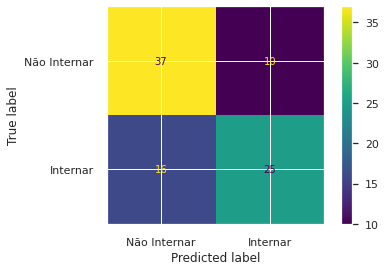

In [ ]:
plotar_confusion_matrix(dados_limpos,modelo_logistico_dados_limpos)

Temos, para cada Label:

* VERDADEIRO POSITIVO (a pessoa precisa de UTI e o modelo acertou) **(VP)**
* VERDADEIRO NEGATIVO (Acerto quando a pessoa não precisa de UTI)**(VN)**  
* FALSO POSITIVO (Quando minha label é zero mas meu modelo diz que é 1) **(FP)**
* FALSO NEGATIVO (Quando minha label é um mas meu modelo diz que é 0) **(FN)**

Isso significa que nosso modelo acertou 37 vezes os dados reais (verdadeiro positivo) no que tange a pacientes que não precisariam de UTI, mas em compensação, erraram 10 vezes, classificando que os pacientes precisariam de UTI quando na verdade não precisavam (falso posivitivo).<br>
Em baixo temos que meu modelos acertou 28 vezes quando o paciente realmente foi pra UTI e o modelo classificou isso (verdadeiro negativo). Contudo, errou 13 vezes quando classificou que alguém não precisaria de UTI quando na verdade, o paciente precisou (falso negativo).<br>
Na minha opinião, pior do que uma UTI que coloca mais gente do que o  necessário internado lá, é um modelo que classifica uma pessoa que realmente precisa de um leito e é classificada como alguém que não necessita.

A partir disso, podemos utilizar em várias métricas para nos aprofundarmos mais e buscar uma precisão melhor. Faremos isso, analisando os resultados para zeros e uns, afinal, estamos realizando uma classificação. A imagem abaixo, resumirá os cálculos realizados pelo método apresentado abaixo.

<img src="https://miro.medium.com/max/550/1*t1vf-ofJrJqtmam0KSn3EQ.png">

Usando o `classification report` do Sklearn, podemos, passando os dados `y_test_lg` que são os dados reais, junto da nossa predição de testes `predicao_lg_dados_limpos`, podemos conferir tais métricas.

In [ ]:
roda_modelo(modelo_logistico_dados_limpos,dados_limpos)

AUC: 0.8240788790866632

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        47
           1       0.72      0.71      0.72        41

    accuracy                           0.74        88
   macro avg       0.74      0.74      0.74        88
weighted avg       0.74      0.74      0.74        88



O que acontece é que para valores 0 (zero - paciente não precisa de UTI), possuímos uma precisão de 74%, assim como para os valores iguais a 1 (um - paciente precisa de UTI). A importância da **PRECISÃO** se dá pelo seguinte fato:

> *A precisão pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos.*

Isso quer dizer que a precisão será importante para a situação em que estamos internando mais pacientes do que  o necessário nas UTI's. Os falso positivos acabam que por lotar toda a estrutura de nosso hospital e consequentemente fará com que as pessoas que realmente precisem, fiquem sem leito disponível. Outro problema gravíssimo é o caso de pacientes que precisam de UTI, mas o modelo interpreta que não necessitam. Neste caso, avaliamos pelo **RECALL**: 

> *O recall pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos.* 

Conforme o print acima, o recall ou sensibilidade, como também é conhecido, para os valores da classe zero possuem um desempenho maior  (79%) do que os da classe um (68%). Isso demonstra que nosso modelos Logistic Regression para o conjunto de dados `dados_limpos`, que é o com maior quantidade de colunas, está sentindo um pouco de dificuldade em interpretar quem vai necessitar de UTI, em comparação aos dados reais. <br>
Temos que o f1-Score nos mostrar, a partir de uma média harmônica entre a precisão e o Recall, que está muito mais próxima dos menores valores do que uma média aritmética simples. No caso da classe zero, seu valor é  de 76% e da classe um, de 71%.

O valor AUC para este modelo está dando um valor igual a 74, semelhante ao que obitivemos no inicio.

Podemos ainda, visualizar nossos coeficientes usados neste modelo. Com a ajuda do  `Yellowbrick` podemos visualizar  a importância dos atributos para o desempenho do modelo. Contudo, por conta da grande quantidade de dados, ficará difícil analisar corretamente. Talvez a grande quantidade de colunas possa ser um problema e `dados_limpos`pode não ser o dataset mais adequado. Vejamos:

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


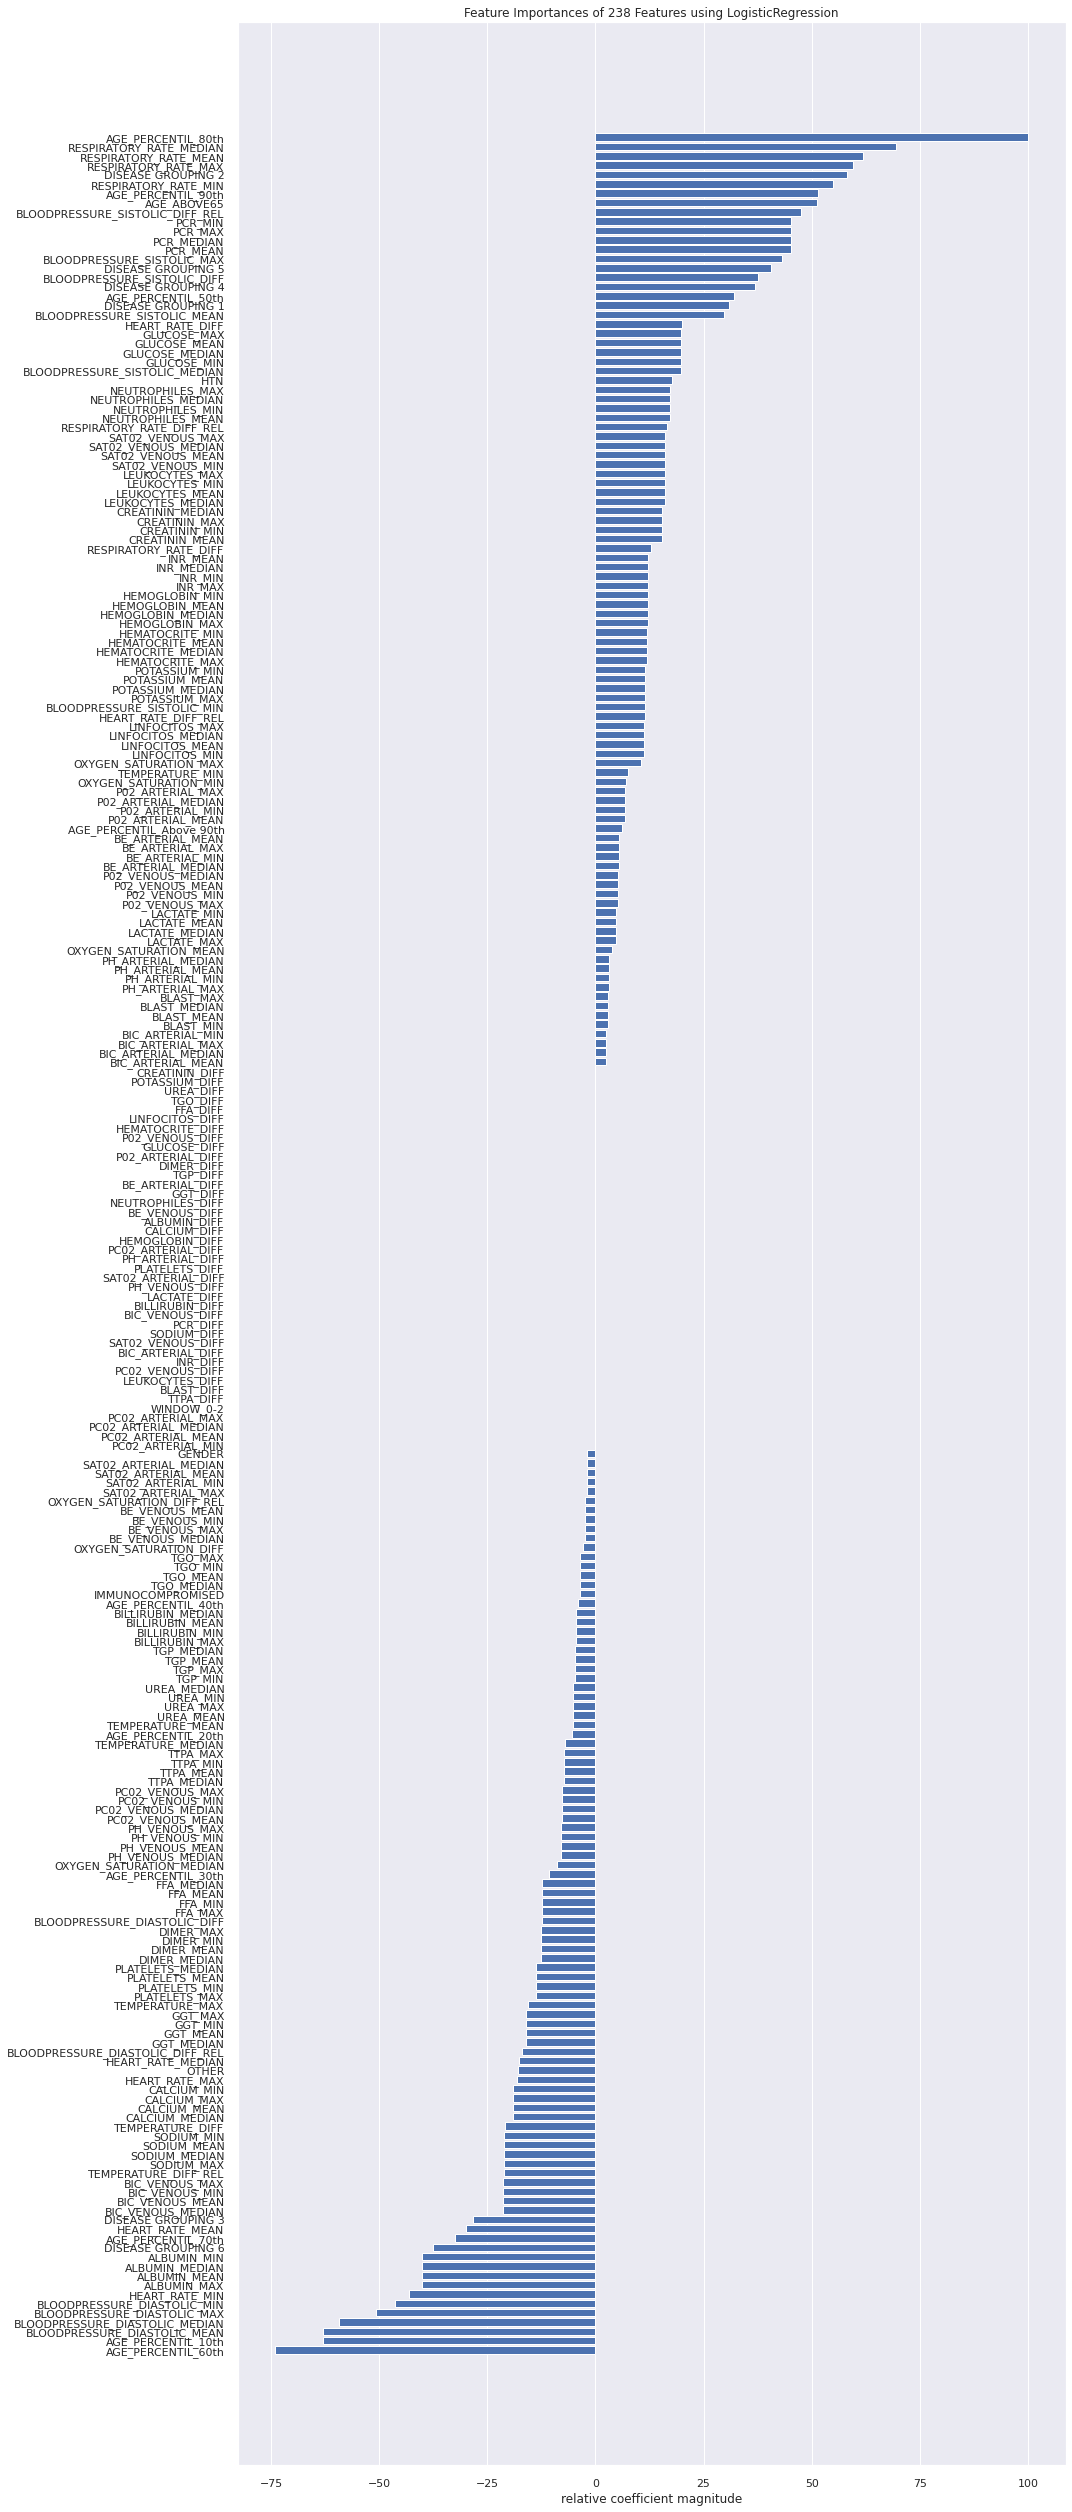

In [ ]:
plotar_FeatureImportances(dados_limpos,modelo_logistico_dados_limpos)

A grande quantidade de colunas impacta em uma boa visualização do gráfico sem que este não fique cortado. <br>Este gráfico é plotado a partir da utilização da função inversa de logit. Mais informações sobre o funcionamento desta função você pode ler [aqui](https://monografias.ufma.br/jspui/bitstream/123456789/3572/1/LEANDRO-GONZALEZ.pdf).<br>
Se `AGE_PERCENTIL_Above_70th` for maior, o paciente tem mais chances de necessitar de uma UTI. Interpretando melhor em um cenário do mundo real, mesmo não sabendo o que `DISEASE GROUPING 3` contenha de doenças agrupadas, temos que seria natural um paciente com idade acima de 70 anos precisar de internação, dados que pela sua idade avançada, o metabolismo trabalhar de forma mais lenta, e que o sistema imunológico também já não possui o mesmo desempenho. Além do mais.Fazendo de forma inversa, ao que tudo indica, a coluna `BLOODPRESSURE_DIASTOLIC_MEDIAN` tem um impacto menor na necessidade de internação na UTI.<br>
Vale resaltar que este gráfico refletem os dados de **TESTE**.

Plotando então a curva ROC o desempenho do modelo até agora. 
<br>
> **Observação**: A curva ROC mostra o quão bom o modelo criado pode distinguir entre duas coisas (já que é utilizado para classificação). Essas duas coisas podem ser 0 ou 1, ou positivo e negativo. Os melhores modelos conseguem distinguir com precisão o binômio.

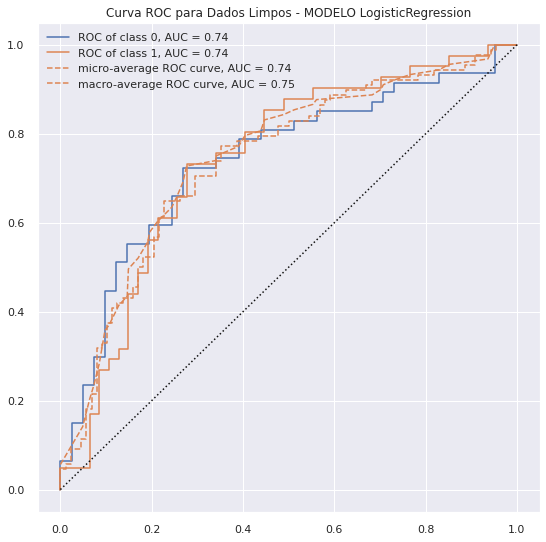

In [ ]:
plotar_roc_auc(modelo_logistico_dados_limpos,dados_limpos, "Dados Limpos")

>**CURVA DE APRENDIZAGEM**

Para selecionar o melhor modelo para o seu projeto, quantos dados serão necessários? Uma curva de aprendizado pode nos ajudar a responder essa pergunta. O gráfico mostra as instâncias de treinamento e a pontuação para validação cruzada à medida que criamos modelos com mais amostras.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


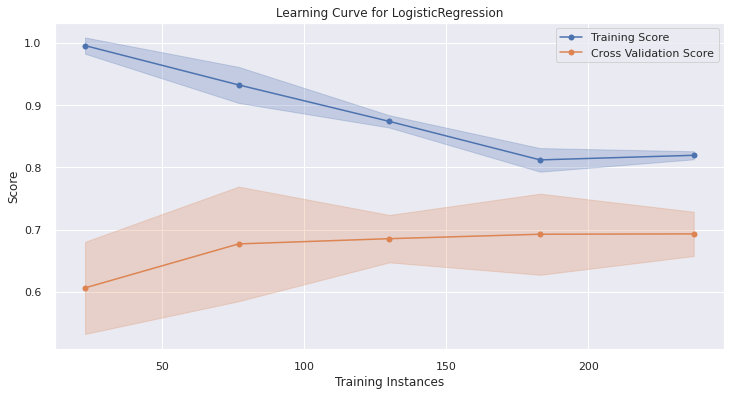

In [ ]:
curva_aprendizagem(modelo_logistico_dados_limpos,dados_limpos)

No modelo Logistico, temos que conforme vamos adicionando mais dados nos trreinamentos (linha azul), nosso desempenho parece ir caindo mais. Em relação pontuação de validação cruzada, conforme vamos adicionando mais valores no treinamento, mais ele vai crescendo, até indicar uma estacionaridade.  Pelo que podemos analisar pela variabilidade na área laranja (área sombreada), nosso modelo sofre de erros de bias ou está sofrendo de superadequação (ser um modelo complicado demais).

##### **DADOS LIMPOS SEM CORRELAÇÃO TIPO 2**
---

Realizando os mesmos procedimento feitos anteriormente em `dados_limpos`, teremos o seguinte.
<br>
<br>
Primeiro, a divisão dos dados para adequação ao Sklearn. Cria-se o conjunto de treinos e testes, mas agora, usando o dataframe `dados_limpos_sem_corr_tipo_2`.

In [ ]:
modelo_logistico_dados_sem_corr = LogisticRegression(max_iter=1000000)

Treinamos o modelo logístico agora com os dados de treino e logo depois realizamos sua predição. Por fim determinamos sua acurácia.

In [ ]:
saber_acuracia(dados_limpos_sem_corr_tipo_2,modelo_logistico_dados_sem_corr)

A acurácia do Modelo Logístico para dados_limpos é de : 65.91 %


A acurácia apresentou um desemepenho inferior aos testes iniciais, mas por quê?<br>
Isso ocorre pelo fato de estarmos usando parâmetros diferentes. Na função usada inicialmente no treinamento de todos os modelos, utilizamos o método

```` 
StratifiedKFold(n_splits=5,shuffle=True)
````
que implica em uma stratificação dos dados em 5 cortes. Toda essa manipulação implica no aumento da pontuação do nosso modelo, pois este é treinado mais adequadamente. Apesar de tudo isso, nosso foco de ir treinando os modelos e ir entendendo melhor desempenho aplicado as classes zero e um não será afetado.

Plotamos novamente a matriz de confusão e temos o seguinte:

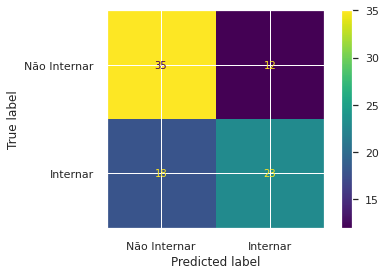

In [ ]:
plotar_confusion_matrix(dados_limpos_sem_corr_tipo_2,modelo_logistico_dados_sem_corr)

Aqui, nossos valores indicam que acertamos 27 vezes quando era necessário internar alguém na UTI, assim como acertamos 31 vezes quando não deveríamos internar alguém na UTI. Por outro lado, o modelo errou 15 vezes com o caso de falso positivos que não precisavam de UTI, mas o modelo acusou que precisavam assim como no caso de falsos negativos, pacientes que precisavam de UTI mas que o modelo acusou que não precisavam, com o valor de 14 vezes.

O classification report nos mostra que as estimativas estão piores aqui do que em comparação ao uso do dataframe `dados_limpos`. A precisão em ambas as classes está abaixo de 70%, assim como o recall. Lembrando que uma ajuda em  identificar os falsos positivos e outro para falso negativos. Ambos causam um grande problema na estrutura e logistica do hospital, além do principal problema que é **por vidas em risco**.

In [ ]:
roda_modelo(modelo_logistico_dados_sem_corr,dados_limpos_sem_corr_tipo_2)

AUC: 0.8038401660612351

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        47
           1       0.72      0.71      0.72        41

    accuracy                           0.74        88
   macro avg       0.74      0.74      0.74        88
weighted avg       0.74      0.74      0.74        88



Veja que o valor AUC subiu próximo a cada dos 80%. Tivemos uma melhora no modelo, apenas implementando um `n_iter` maior que padrão usando o dataframe `dados_limpos_sem_corr_tipo_2`.

Abaixo, plotamos novamente o gráfico mostrando a importância das colunas para o modelo de Logistic Regression, usand os  dados de teste.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


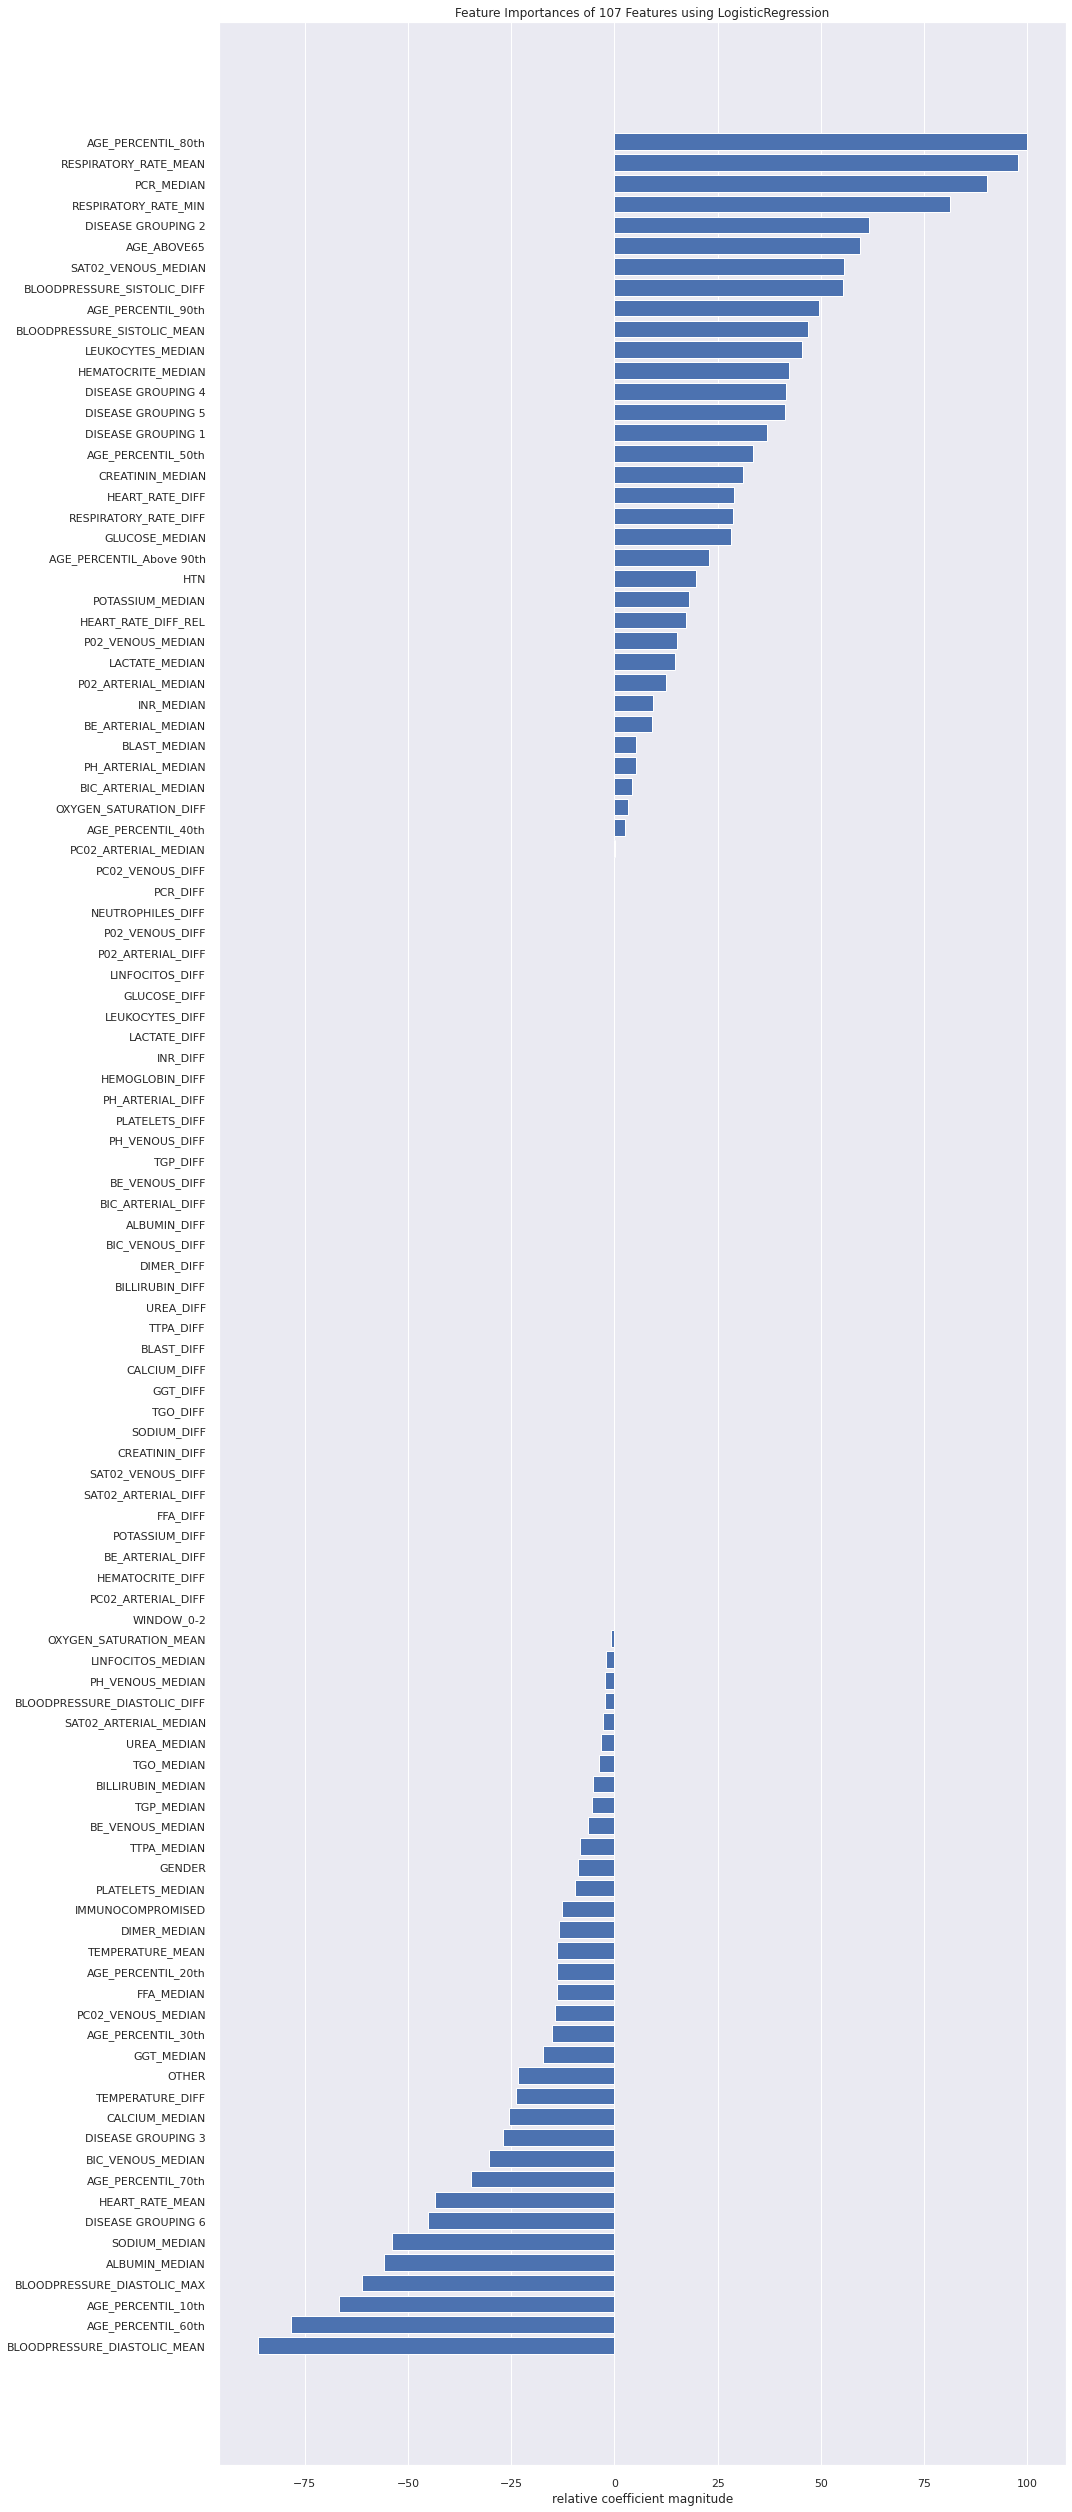

In [ ]:
plotar_FeatureImportances(dados_limpos_sem_corr_tipo_2,modelo_logistico_dados_sem_corr)

Observe que diferente do gráfico que tivemos quando usamos o dataframe `dados_limpos`, aqui `AGE_PERCENTIL_50th` apresentou um coeficiente de magnitude positivo superior a 75, diferente de `BLOODPRESSURE_DIASTOLIC_MEAN`.

Plotamos aqui também nossa curva ROC para termos uma ideia de como este conjunto de dados está se saindo.

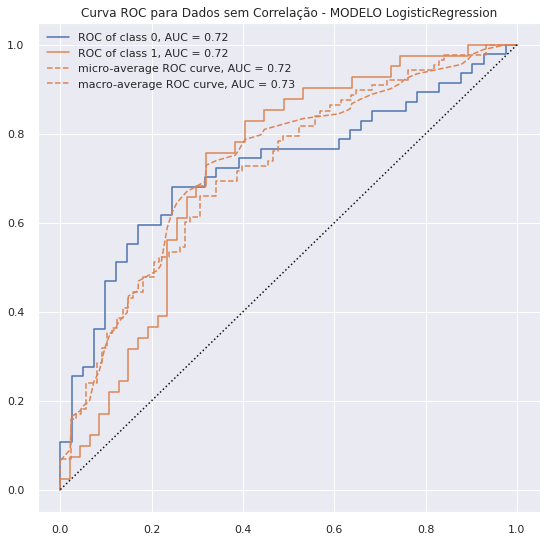

In [ ]:
plotar_roc_auc(modelo_logistico_dados_sem_corr,dados_limpos_sem_corr_tipo_2,"Dados sem Correlação")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


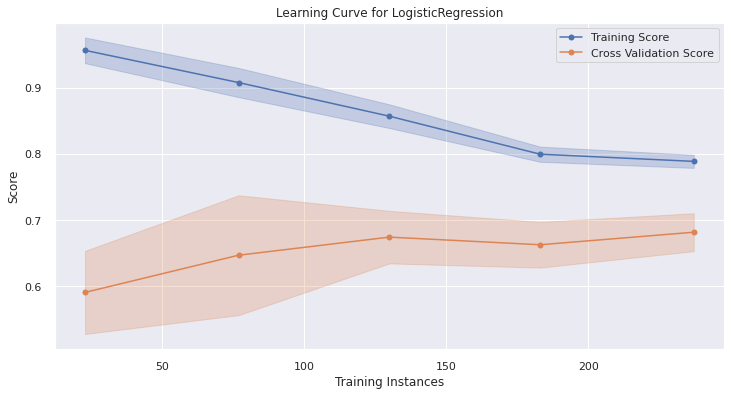

In [ ]:
curva_aprendizagem(modelo_logistico_dados_sem_corr,dados_limpos_sem_corr_tipo_2)

Neste caso, com este conjunto de dados e sem modificações grandes nos hiperparâmetros do modelo, conforme vamos adicionando mais e mais dados, maior vai se tornando pontuação da validação cruzada. Ainda assim, ele parece sofrer de superadequação.

## 📘 RANDOM FOREST CLASSIFIER

Aplicaremos agora o modelo conhecido Random Forest Classifier e buscaremos analisar seu desempenho nos dois dataframes.

##### **DADOS LIMPOS**
---

Primeiramente, instanciamos a classe, mas desde já passamos um `n_estimators  = 100 ` que servirá para evitar uma superadequação dos dados.

In [ ]:
modelo_random_dados_limpos = RandomForestClassifier(n_estimators=100)

Desde de já, vejamos sua acurácia:

In [ ]:
saber_acuracia(dados_limpos,modelo_random_dados_limpos)

A acurácia do Modelo Logístico para dados_limpos é de : 65.91 %


Você deve ter precebido que esse modelo demora um pouquinho mais para executar certo? Esse é uma das desvantagens dele.

Vejamos como sua matriz de confusão se comporta

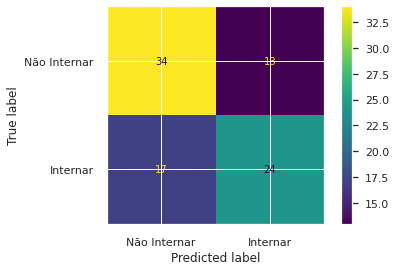

In [ ]:
plotar_confusion_matrix(dados_limpos,modelo_random_dados_limpos)

Diferente dos modelos em Logistic Regression, aqui podemos notar uma mudança sifgnificativa na contagem de acertos para pacientes que não devem ser internados. Contudo, para pacientes que devem ser internados (nosso foco aqui), o valor parece continuar parecido com os casos anteriores.

In [ ]:
roda_modelo(modelo_random_dados_limpos,dados_limpos)

AUC: 0.8087701089776854

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        47
           1       0.70      0.80      0.75        41

    accuracy                           0.75        88
   macro avg       0.75      0.75      0.75        88
weighted avg       0.76      0.75      0.75        88



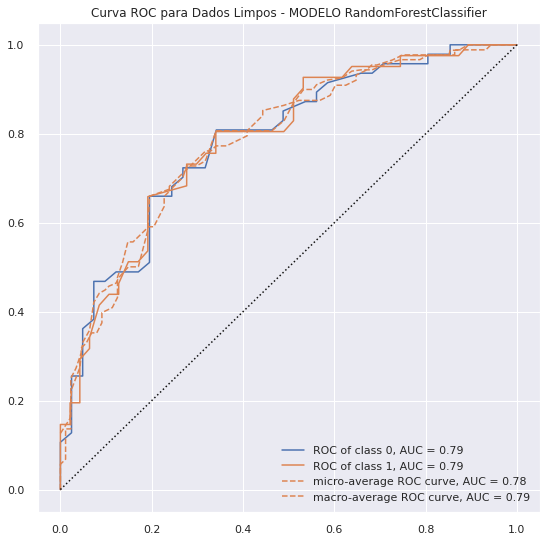

In [ ]:
plotar_roc_auc(modelo_random_dados_limpos,dados_limpos,"Dados Limpos")

Com o resultado da curva AUC acima, podemos notar que a forma como este modelo vem desempenhando ainda depende de hiperparâmetros mais ajustados ao seu individualismo. Precisamos especificar cada vez mais o modelo. Para isso, realizaremos uma otimização em seus parâmetros.

> **CURVA DE VALIDAÇÃO** para o modelo **RandomForestClassifier**

Como Matt Harisson define em seu livro *Machine Learning - Guia de Referência Rápida*, curva de validação:
> É uma forma de determinar um valor apropriado para um hiperparâmetro que mostra como o desemepnho do modelo responde a mudanças no valor do hiperparâmetro.


Nosso objetivo é descobrir bons valores para o hiperparâmetro **max_depth**, responsável pela **profundidade** da árvore.
Vejamos então como ele se comporta em um valor de 1 até 15:

><font color='red'> **OBSERVAÇÃO**: **OS VALORES DO EIXO-Y NÃO INICIAM NO VALOR 0 , POIS OS GRÁFICOS SÃO GERADOS AUTOMATICAMENTE E,PRESSUPÕE-SE QUE MOSTRAR A PARTIR DE UM VALOR IGUAL A 0.6 OU 60% (COMO NO NOSSO CASO)  TORNA A VISUALIZAÇÃO MELHOR PARA OS RESULTADOS. ISSO SE REFLETIRÁ EM TODOS OS PLOTS DE CURVA DE VALIDAÇÃO E CURVA DE APRENDIZAGEM** </font>

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


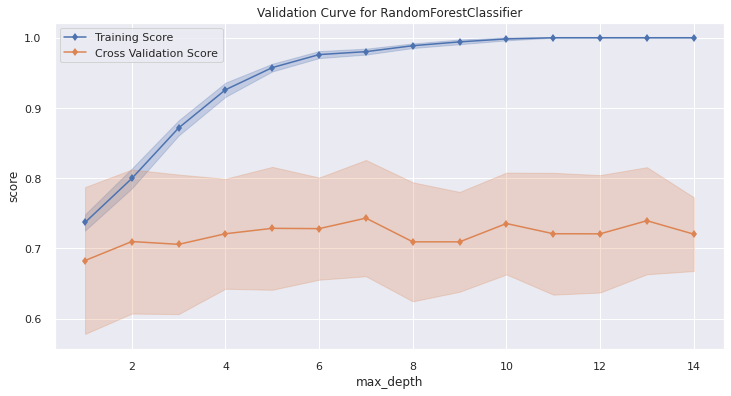

In [ ]:
curva_validacao(modelo_random_dados_limpos, dados_limpos,15,'max_depth')

Em azul temos a pontação de treino, que a cada valor max_depth vai se aproximando de 1.00 ou 100% de pontuação, levando a um **overfitting**. Isso significa que o modelo se ajusta tanto ao modelo de treinamento que beira a perfeição. Parece até bom mas na prática não é, pois visualizando a linha laranja, que representa nossos dados de teste, ficamos sempre entre o invervalo de  65 a 75 de pontuação. 
<br>
A pontuação dos dados de validação nos permitem inferir como o modelo responderia a dados não previstos anteriormente. No geral, buscamos um hiperparâmetro que maximize a pontuação da validação dos dados.
<br>
Dado a análise, o melhor max_depth para o modelo é **max_depth = 11** para o *RandomForestClassifier*.


Analisando o número mínimo de amostras em cada folha (`min_samples_leaf`).

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


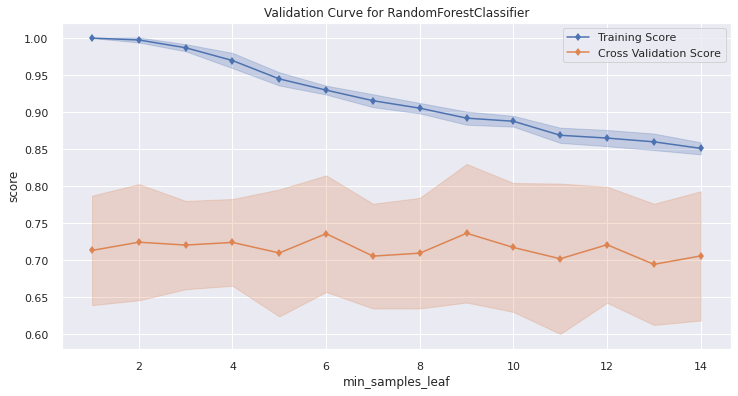

In [ ]:
curva_validacao(modelo_random_dados_limpos, dados_limpos,15,'min_samples_leaf')

setar o parâmetro para 8 parece ser uma boa ideia.

Conferindo agora o `min_samples_split`, que vem a ser o número mínimo de amostras para separar um nó.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


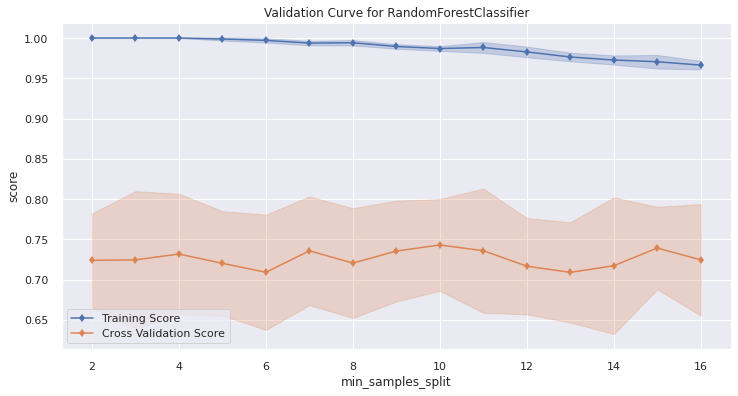

In [ ]:
curva_validacao(modelo_random_dados_limpos, dados_limpos,17,'min_samples_split')

O valor setado para 13 nos parece ser uma boa opção.

Analisnado a curva de aprendizagem agora.

Possuímos uma quantidade pequena de dados para trabalhar. Com a curva vemos que nossos modelos vai precisando de mais dados com o tempo. A curva em azul, que é a pontuação de treinamento, deixa claro que não precisaríamos de mais dados para treinamento, diferente da linha laranja que indica os dados de validação.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


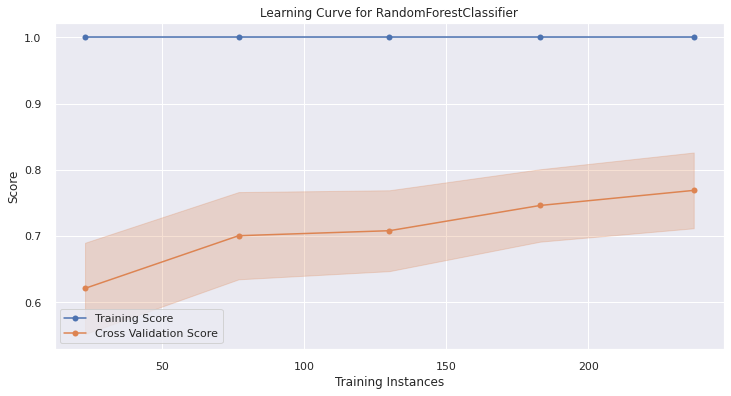

In [ ]:
curva_aprendizagem(modelo_random_dados_limpos,dados_limpos)

Ao que tudo indica, com os valores no padrão em que está até o momento, o modelo se encaminha para uma superadequação e isso o torna mais complicado.

##### **DADOS SEM CORRELAÇÃO TIPO 2**
---

Agora, realizaremos os mesmos processos para estes conjunto de dados. Isso significa que muitas coisas não ser explicadas novamente. Vamos nos ater aos resultados.

In [ ]:
modelo_random_dados_limpos_gondinni = RandomForestClassifier(n_estimators=100)

In [ ]:
saber_acuracia(dados_limpos_sem_corr_tipo_2,modelo_random_dados_limpos_gondinni)

A acurácia do Modelo Logístico para dados_limpos é de : 65.91 %


Primeiramente,  nossa acurácia aponta um valor abaixo do que fora demonstrado quando rodamos este mesmo modelo, sem nenhuma modificação, na primeira vez.

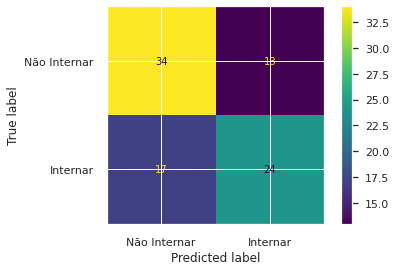

In [ ]:
plotar_confusion_matrix(dados_limpos_sem_corr_tipo_2,modelo_random_dados_limpos_gondinni)

Contudo, analisando para este dataset, notamos que o número de acertos dos dados previstos e os dados reais para pacientes que necessitam de internação foi menor do que no dataframe `dados_limpos`,assim como na predição de pacientes falso positivos que foi maior.

In [ ]:
roda_modelo(modelo_random_dados_limpos_gondinni,dados_limpos_sem_corr_tipo_2)

AUC: 0.8087701089776854

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        47
           1       0.70      0.80      0.75        41

    accuracy                           0.75        88
   macro avg       0.75      0.75      0.75        88
weighted avg       0.76      0.75      0.75        88



Observe que o valor AUC para o modelo que usa este dataframe, foi maior que o modelo que usa o outro dataframe.

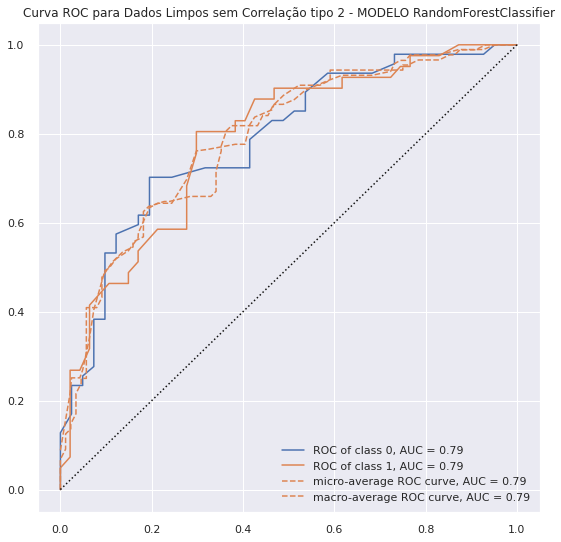

In [ ]:
plotar_roc_auc(modelo_random_dados_limpos_gondinni,dados_limpos_sem_corr_tipo_2,"Dados Limpos sem Correlação tipo 2")

Sua curva Roc também apresentou desempenho melhor. 

Agora, analisando os hiperparâmetros `max_depth`, `min_samples_leaf` e `min_samples_split` temos que: 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


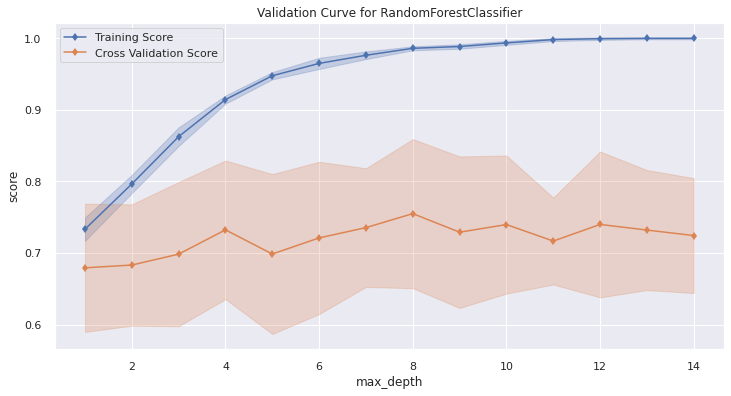

In [ ]:
curva_validacao(modelo_random_dados_limpos_gondinni, dados_limpos_sem_corr_tipo_2,15,'max_depth')

O melhor valor para usarmos parece ser 14 tanto para `max_depth` quanto para `min_samples_leaf`.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


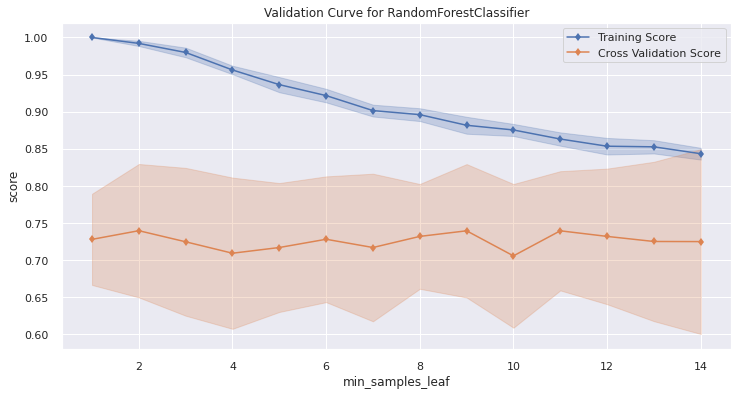

In [ ]:
curva_validacao(modelo_random_dados_limpos_gondinni, dados_limpos_sem_corr_tipo_2,15,'min_samples_leaf')

Para `min_samples_split`, o melhor valor aparenta ser 10.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


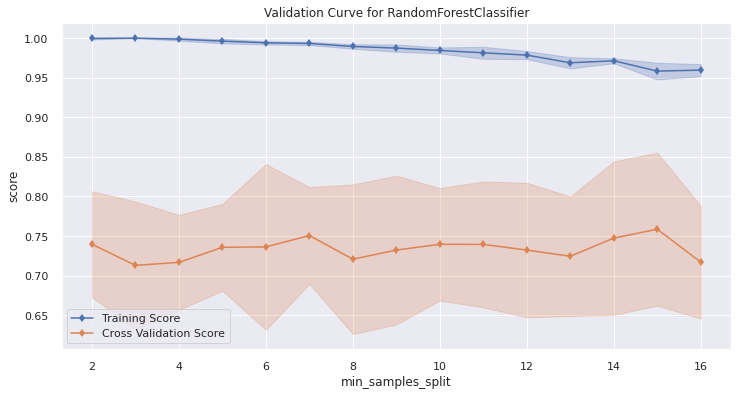

In [ ]:
curva_validacao(modelo_random_dados_limpos_gondinni, dados_limpos_sem_corr_tipo_2,17,'min_samples_split')

Para a curva de aprendizagem, fica claro que precisamos de mais dados.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


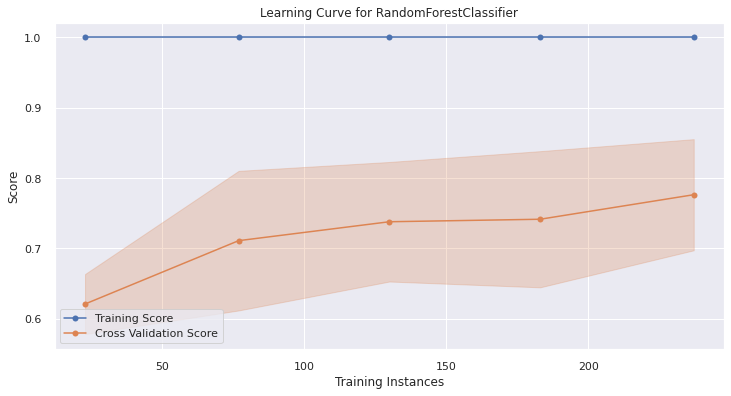

In [ ]:
curva_aprendizagem(modelo_random_dados_limpos_gondinni,dados_limpos_sem_corr_tipo_2)

Quanto a curva de aprendizado, observe que 

## 📘 XGBOOST CLASSIFIER

Por último mas não menos importante, iremos trabalhar com o modelo XGBoost. Este modelo não faz parte do conjunto d Sklearn mas também é muito bom e robusto. Aqui, o processo também será semelhante aos casos anteriores. 

##### **DADOS LIMPOS**
---

Começamos então instanciando a classe e passando um estimador igual a 100 (que já vem por padrão, mas que é bom explicitar). Além disso, passo também, um `n_jobs` igual a menos um (-1). Isso significa que, para ter um maior ganho de performance, o modelo usará todas as threads disponíveis na CPU.

In [ ]:
modelo_xgboost_dados_limpos = XGBClassifier(n_estimators=100,n_jobs=-1)

A acurácia inicial do modelo é baixa, como podemos analisar.

In [ ]:
saber_acuracia(dados_limpos,modelo_xgboost_dados_limpos)

A acurácia do Modelo Logístico para dados_limpos é de : 69.32 %


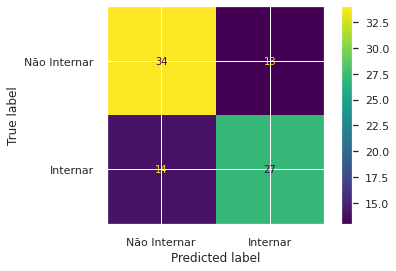

In [ ]:
plotar_confusion_matrix(dados_limpos,modelo_xgboost_dados_limpos)

Sua matriz de confusão é semelhante a do random forest de `dados_limpos_sem_corr_tipo_2`. Até então, não temos nada demais.

In [ ]:
roda_modelo(modelo_xgboost_dados_limpos,dados_limpos)

AUC: 0.773741567202906

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        47
           1       0.63      0.71      0.67        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.68      0.67      0.67        88



Com relação as métricas de precisão para os valores de classe 0, temos um desempenho menor que os modelos Logistic Regression. O recall dele indica que está conseguindo identificar em 71% os casos de falsos positivos.

Quanto a sua curva ROC, ele demonstra uma boa margem de crescimento.

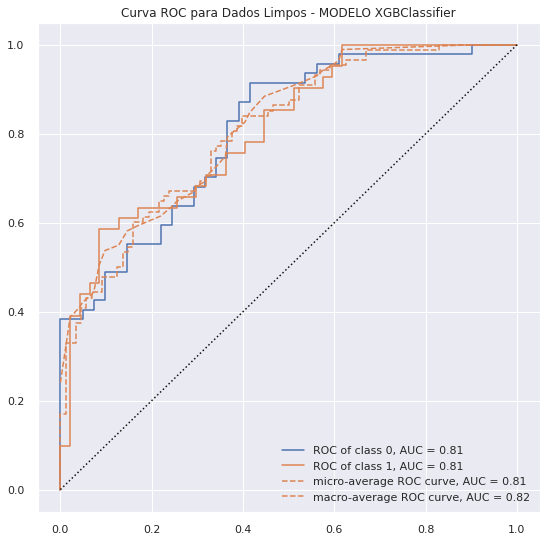

In [ ]:
plotar_roc_auc(modelo_xgboost_dados_limpos,dados_limpos,"Dados Limpos")

Buscando entender quais as métricas serão boas para ele, aplicamos a função apenas para max_depth que é referente a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado nos dados de treinamento, também conhecido como overfitting. Profundida de menos vai diminuir a capacidade de generalização do modelo.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


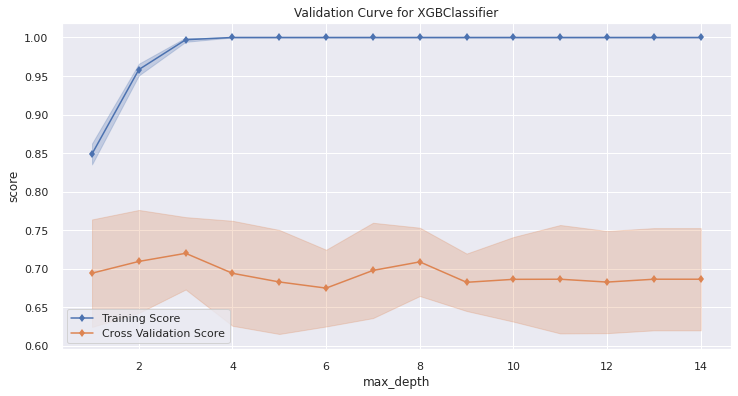

In [ ]:
curva_validacao(modelo_xgboost_dados_limpos, dados_limpos,15,'max_depth')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


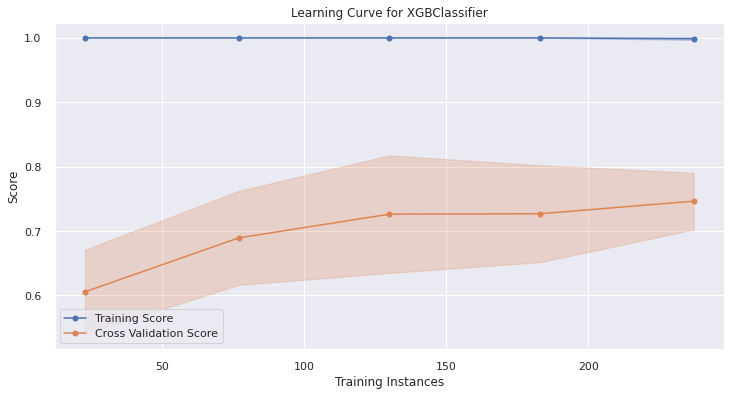

In [ ]:
curva_aprendizagem(modelo_xgboost_dados_limpos,dados_limpos)

Com relação a curva de aprendizagem, o modelo pede por mais dados. Assim, ele vem a ter um desepenho melhor.
<br>
Um fator importante que esta biblioteca possue é fato de plotar quais colunas apresentam maior importância no momento em que estão rodando. Abaixo, você pode vizualizar quais colunas estão sendo mais importantes e sua "pontuação" de importância.

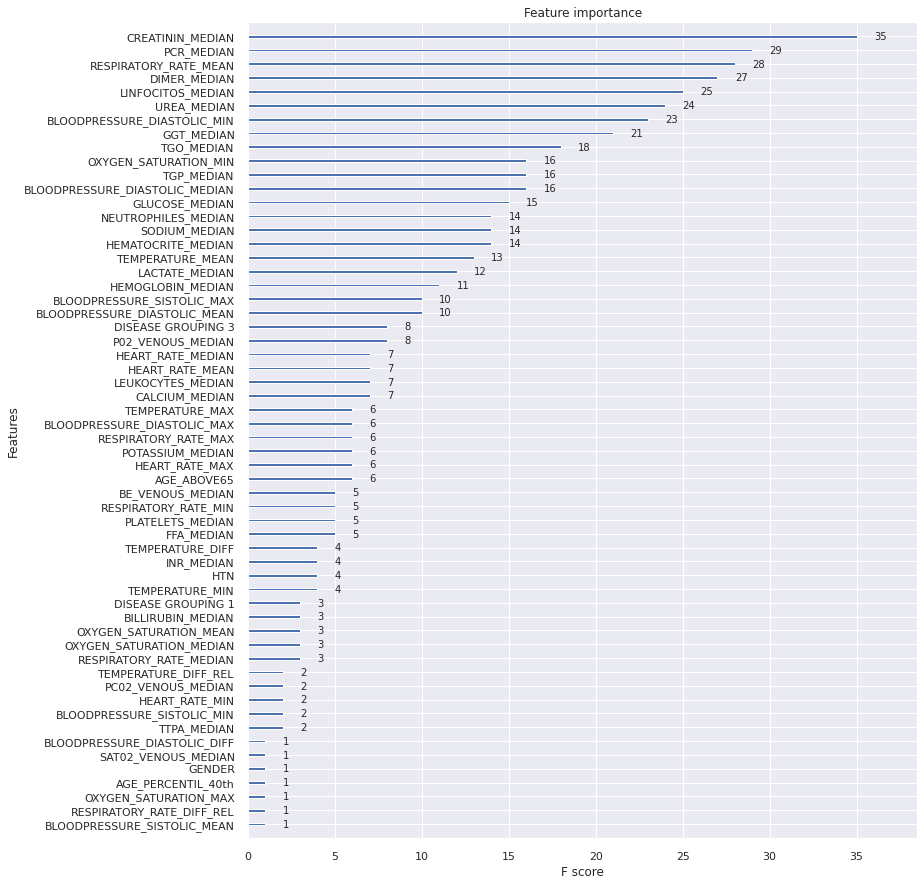

In [ ]:
import xgboost as xgb

fig,ax = plt.subplots(figsize=(12,15))
xgb.plot_importance(modelo_xgboost_dados_limpos,ax = ax)
plt.show()

Podemos ainda, tentar descobrir quais parâmetros, melhor desempenham no nosso modelo XGBoost. Com o auxílio do Grid Search CV, iremos passar um dicionário com os hiperparâmetros que desejamos em nosso modelo. Iremos então buscar o melhor estimador para os valores passados e no fim, plotarei o tempo em segundos para executar tudo isso e  pontuação no formato `roc_auc` para os dados de Treino e Teste, além do melhor modelo que ele conseguiu gerar com os hiperparâmetros.

In [ ]:
param_grid_usado = {
            "max_depth": [5,8,10,20],
            "n_estimators": [25, 50, 100,200,1000],
            'min_child_weight':[4,5,6],
            'objective':['binary:logistic'],
            'gamma':[i/10.0 for i in range(0,4)]

}

In [ ]:
buscar_melhor_parametro(dados_limpos,modelo_xgboost_dados_limpos,param_grid_usado)

Tempo execução: 279.06682896614075 segundos

TREINO :1.00 
TESTE :0.79 


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Perceba que demora um certo tempo para que ele rode tudo. A ideia por trás disso é ter uma ideia do que torna o modelo melhor, por isso precisamos testar possibilidades que possam criar até mesmo uma certa demora. Não significa que um modelo final resulte nisso, apenas que para encontrarmos os valores mais adequados, a paciência terá que ser nossa amiga.<br>
<br>
**Observação**: Por que não apliquei isso nos modelos anteriores? 
<br> Simples. Aplicando isso nos modelos anteriores, demoríamos de minutos a horas, apenas pra descobrir as melhores combinações. Buscando evitar isso, separei a técnica apenas para o XGBoost Classifier, que é uma biblioteca muito rica e que exige de nós um pouco mais de conhecimento sobre Machine Learning. 

Assim, com os resultaodos, vamos ver se fará ou não alguma diferença, usar esses parametros.
* modelo_teste_xgb_ds = modelo teste xgboost dados limpos

In [ ]:
modelo_teste_xgb_ds =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Ao executar esse modelo novo, com tudo que nos fora indicado a por, temos este resultado.

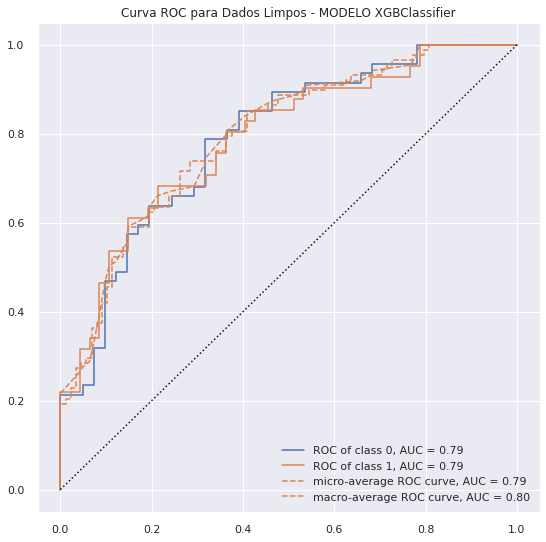

In [ ]:
plotar_roc_auc(modelo_teste_xgb_ds,dados_limpos,"Dados Limpos")

E, originalmente, sem mexer em parâmetros, e apenas passar n_estimador = 100 e n_jobs = -1 , tivemos isso:

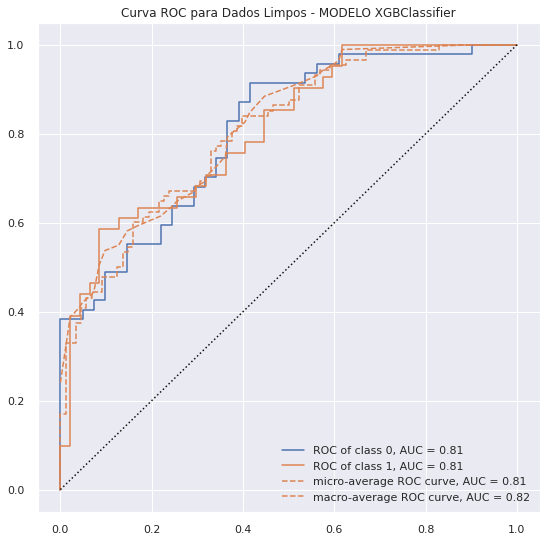

In [ ]:
plotar_roc_auc(modelo_xgboost_dados_limpos,dados_limpos,"Dados Limpos")

Ou seja, ao que tudo indica, a pouca mudança que realizamos nos dados  orignalmente teve um efeito mais positivo do que o contrário. 

##### **DADOS SEM CORRELAÇÃO TIPO 2**
---

Iremos repetir os processos mas agora usando outro conjunto de dados.

In [ ]:
modelo_xgboost_gondinni = XGBClassifier(n_estimators=100,n_jobs=-1)

In [ ]:
saber_acuracia(dados_limpos_sem_corr_tipo_2,modelo_xgboost_gondinni)

A acurácia do Modelo Logístico para dados_limpos é de : 72.73 %


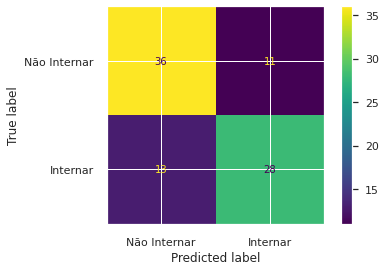

In [ ]:
plotar_confusion_matrix(dados_limpos_sem_corr_tipo_2,modelo_xgboost_gondinni)

Com esse conjunto de dados, tivemos um desempenho minimamente superior.

In [ ]:
roda_modelo(modelo_xgboost_gondinni,dados_limpos_sem_corr_tipo_2)

AUC: 0.766476388168137

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        47
           1       0.62      0.73      0.67        41

    accuracy                           0.67        88
   macro avg       0.68      0.67      0.67        88
weighted avg       0.68      0.67      0.67        88



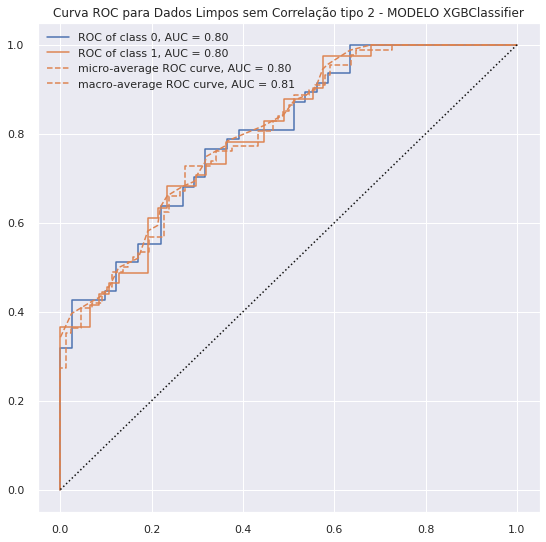

In [ ]:
plotar_roc_auc(modelo_xgboost_gondinni,dados_limpos_sem_corr_tipo_2,"Dados Limpos sem Correlação tipo 2")

Aplicarei novamente a tentativa automática da escolha de parâmetros. 

In [ ]:
param_grid_usado = {
            "max_depth": [5,8,10,20],
            "n_estimators": [25, 50, 100,200,1000],
            'min_child_weight':[4,5,6],
            'objective':['binary:logistic'],
            'gamma':[i/10.0 for i in range(0,4)]

}

In [ ]:
buscar_melhor_parametro(dados_limpos_sem_corr_tipo_2,modelo_xgboost_gondinni,param_grid_usado)

Tempo execução: 279.27634596824646 segundos

TREINO :1.00 
TESTE :0.79 


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Até mesmo seu gráfico apresentou um desempenho um pouco menor que o modelo com os `dados_limpos`.

# 📊 VALIDAÇÃO CRUZADA

Realizamos uma análise dos modelos logo acima, mas faltou apenas tratar da questão da generelização dos dados. Para evitar que nosso modelo vicie e quando chegue na prática, sofra pra tirar algum proveito, aplicaremos a validação cruzada, definida como:

> Cross-validation (Validação cruzada) é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. É fundamental em problemas onde o objetivo da modelagem é a predição.

Busca-se estimar o quão preciso é um modelo na prática, ou seja, o seu desempenho em um novo conjunto de dados.

Idealmente, o modelo deve ser avaliado em amostras que não foram usadas para construir ou ajustar o modelo, de modo que forneçam um senso imparcial de eficácia do modelo. Quando uma grande quantidade de dados está à mão, um conjunto de amostras pode ser reservado para avaliar o modelo final - este é o set de teste - que não deve ser tocado até esta avaliação final. O set de treinamento é usado  para criar o modelo, enquanto o set de validação é usado para ajustar o desempenho.


## **DADOS_LIMPOS**

##### Logistic Regression

In [ ]:
roda_modelo_cv(modelo_logistico_dados_limpos,dados_limpos,5,10)

AUC: 0.7476269316565368 -  0.8707788239215362


(0.7476269316565368, 0.8707788239215362)

##### Random Forest Classifier

In [ ]:
roda_modelo_cv(modelo_random_dados_limpos,dados_limpos,5,10)

AUC: 0.7879505986249409 -  1.0


(0.7879505986249409, 1.0)

XGBoost Classifier

In [ ]:
roda_modelo_cv(modelo_xgboost_dados_limpos,dados_limpos,5,10)

AUC: 0.7722890534074744 -  0.9999786843568655


(0.7722890534074744, 0.9999786843568655)

## **DADOS_LIMPOS_SEM_CORR_TIPO_2**

##### Logistic Regression

In [ ]:
roda_modelo_cv(modelo_logistico_dados_sem_corr,dados_limpos_sem_corr_tipo_2,5,15)

AUC: 0.7499815545210281 -  0.857666744884829


(0.7499815545210281, 0.857666744884829)

##### Random Forest Classifier

In [ ]:
roda_modelo_cv(modelo_random_dados_limpos_gondinni,dados_limpos_sem_corr_tipo_2,5,15)

AUC: 0.7932943544621176 -  1.0


(0.7932943544621176, 1.0)

XGBoost Classifier

In [ ]:
roda_modelo_cv(modelo_xgboost_gondinni,dados_limpos_sem_corr_tipo_2 ,5,15)

AUC: 0.7698108844490422 -  0.9999329304671579


(0.7698108844490422, 0.9999329304671579)

Rodado os modelos, concluí-se que:

**Melhor Modelo**:
* **Random Forest Classifier**

**Melhor conjunto de dados**:
* **dados_sem_corr_tipo_2**


Iremos melhorar um pouco mais esse modelo e extrair um pouco mais de performance. Mesmo que melhorando um pouco, já será de grande ajuda e pode futuramente ser aperfeiçoado.

##Melhorando modelo selecionado

Com base neste [artigo](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/), iremos implementar hiperparâmetros que geralmente auxíliam em um melhor desempenho neste modelo.
<br>
Aplicaremos os seguintes parâmetros:

```

RandomForestClassifier(n_estimators=1000,
                       n_jobs=-1,
                       max_depth=4,
                       min_samples_leaf=6,
                       min_samples_split=6,
                       max_samples = 0.3,
                       max_leaf_nodes = 25)

```                                                    

A partir daqui, irei chamar as mesmas funções (com uma leve mudada em seu código no final), além da criação de uma classe que será usada para a implementação do pipeline.

### Pipeline
---

O pipeline nos auxiliará em reduzir o código e aplicar de forma mais organizada o uso dos nossos modelos. Vejamos sua criação abaixo.

Importarei essas duas classes aqui pois ficará mais fácil de compreender o processo que aplicaremos. O pipeline será usado para que possamos organizar nossos métodos de aplicação de forma mais organizada. Com relação a BaseEstimador e TransformerMixin, temos, conforme mostra a documentação oficial:
> A peça central do transformador, do regressor e do classificador é `sklearn.base.BaseEstimator`. Todos os estimadores em scikit-learn são derivados desta classe. Em mais detalhes, esta classe base permite definir e obter parâmetros do estimador.

Quanto ao TransformerMixin:
>Transformers são estimadores de scikit-learn que implementam um método. ao criar um transformador, você precisa criar uma classe que herda tanto do `sklearn.base.baseestimator` quanto do `sklearn.base.transformerMixin`.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

Definimos uma classe que aplicará a mesma função de limpar os dados e remover colunas com alta taxa de correlação.

In [ ]:
class RemoverCorr(BaseEstimator,TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte

    def fit( self, X, y = None ):
        matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 
        
    def transform(self, X, y = None):
        X = X.drop(self.excluir, axis=1)
        return X

Criamos uma função que funciona semelhantemente a função que aplicamos anteriormente para descobrir qual modelo se saiu melhor. A diferença é que agora, adicionamos a variável pipeline que recebe uma classe Pipeline e essa recebe uma lista com tuplas. `cat_selector` será responsável pela remoção dos dados correlacionados, enquanto que  `modelo` será responsável por receber o modelo que passamos nos parâmetros da função `roda_modelo_cv_pipeline`. 

In [ ]:
def roda_modelo_cv_pipeline(modelo, dados, n_splits, n_repeats):

    np.random.seed(1354537)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU"], axis=1)

    pipeline = Pipeline([('cat_selector', RemoverCorr()),
                         ('Modelo', modelo)])    

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(pipeline, x, y, cv=cv, scoring='roc_auc', return_train_score=True,n_jobs=-1)

    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])

    print(f'AUC  {auc_medio}')

Vamos aplicar toda a execução dos dados. Desde a chamada dos dados diretamente do github onde estão os dados, passando na manipulação dos dados, limpando e preechendo os dados ausentes, aplicando o filtro na coluna `WINDOW`e `ICU`, realizando as querys de colunas a remover. Aplicando o `get_dummies` para transformar os dados categóricos, instanciando ao Modelo, junto de seus parâmetros , rodando a função e retornando o scoring `roc_auc` e o tempo de execução.

>**Observação**: Apesar do nome da variável `dados_limpos`, esta não é a mesma que `dados_limpos` usado ao longo de todo o projeto. Esta é uma variável nova gerada com a aplicação do método de limpeza de dados com alto nível de correlação - TÉCNICA GONDINNI.

In [ ]:
dados_original = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
start_time = time.time()
np.random.seed(45438)

dados_limpos = preenche_tabela(dados_original)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos.dropna(inplace=True)
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos)
dados_limpos = remove_corr_var(dados_limpos)

melhor_random_dados_limpos = RandomForestClassifier(n_estimators=1000,
                                                    n_jobs=-1,
                                                    max_depth=4,
                                                    min_samples_leaf=6,
                                                    min_samples_split=6,
                                                    max_samples = 0.3,
                                                    max_leaf_nodes = 25)

roda_modelo_cv_pipeline(melhor_random_dados_limpos,dados_limpos,5,10)
print("\033[1m" + f"Tempo de execução: {(time.time() -  start_time )}  secs." + "\033[0m")

AUC  0.8079591523341526
Tempo de execução: 83.31744122505188  secs.


Temos no fim, um scoring igual a 80.61%. com um tempo de execução próximo aos 83 segundos ou aproximadamente 1 minuto e 30 segundos para executar todo.

Apenas por curiosidade, também apliquei os mesmos métodos ao modelo XGBoost. Usando as configurações recomendadas pelo `GridSearchCV`. Os resultados para este conjunto de dados `dados_limpos_sem_corr_tipo_2`foram selecionados.

```
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
```              

Mudarei apenas o `n_estimadors` para igual a `50`.

Vejamos então como ele desempenha.


In [ ]:
dados_original = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
start_time = time.time()
np.random.seed(45438)

dados_limpos = preenche_tabela(dados_original)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos.dropna(inplace=True)
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos)
dados_limpos = remove_corr_var(dados_limpos)

melhor_xgboost_dados_limpos = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

roda_modelo_cv_pipeline(melhor_xgboost_dados_limpos,dados_limpos,5,10)
print("\033[1m" + f"Tempo de execução: {(time.time() -  start_time )}  secs." + "\033[0m")

AUC  0.7746681564938145
Tempo de execução: 15.460039854049683  secs.


Seu AUC foi menor que o modelo **RandomForestClassifier**, contudo, seu tempo de execução foi menor. Menos de  10 segundos

#CONCLUSÃO

Dado o desenolvimento aplicado no projeto, temos então dois modelos que tiveram melhores resultados. A partir daí vem a questão, queremos mais acertos a custa de um tempo maior de processamento ou um processamento e execução mais rápido mas com um scoring um pouco menor. Caberá a diretoria escolher o que melhor possa auxiliar no nosso caso real. Na minha opinião, o XGBoost Claasifier pode ser a melhor opção no momento, mas que nada possa  ser aperfeiçoado no modelo RandomForestClassifier.<br>
Independente da escolha, a luta por vidas dependerá ainda do corpo médico que está na linha de frente e espero que este projeto possa ajudar eles na melhor tomada de decisão. <BR>
Um adendo importante é : o projeto está finalizado no momento, contudo, ele será aperfeiçoado ao longo dos meses e tem muito a evoluir, pois a cada remessa nova de dados, manutenções deverão ser realizadas. Gostaria de agradecer pela oportunidade de desenvolver este projeto e deixo aqui meus agradecimentos ao [João Vítor Perez de Souza](https://github.com/souzajvp) pelo auxílio de desenvolvimento.
<br>

><font color='blue'> **OBSERVAÇÃO**: **NO REPOSITÓRIO DO GITHUB HÁ UM COLAB COM O PIPELINE MONTADO PARA RANDOM FOREST CLASSIFIER E UM PARA XGBOOST CLASSIFIER, PRONTOS PARA IR PARA PRODUÇÃO.** </font>
<br>
<BR>
Muito Obrigado por ler até aqui!

#REFERÊNCIAS

[Sklearn - Modelos Lineares](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

[Regressão Logística - Prof. Adriana Silva](https://www.youtube.com/watch?v=dcsZsA_wipE&ab_channel=EstaTiDados)

[Modelos de Predição | Regressão Logística](https://medium.com/turing-talks/turing-talks-14-modelo-de-predi%C3%A7%C3%A3o-regress%C3%A3o-log%C3%ADstica-7b70a9098e43)
[edisciplinas - usp](https://edisciplinas.usp.br/pluginfile.php/3769787/mod_resource/content/1/09_RegressaoLogistica.pdf)

[Sklearn - 1.9 Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)

[Data Geeks - Classificação com Naive Bayes](https://www.datageeks.com.br/naive-bayes/)


[Modelos de Predição| SVM](https://medium.com/turing-talks/turing-talks-12-classifica%C3%A7%C3%A3o-por-svm-f4598094a3f1)

[Creating a simple binary SVM classifier with python and Scikit-learn](https://www.machinecurve.com/index.php/2020/05/03/creating-a-simple-binary-svm-classifier-with-python-and-scikit-learn/#choosing-a-kernel-function)


[Entendendo classificadores de florestas aleatórias em Python](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)

[XGBoost: A Scalable Tree Boosting System](https://arxiv.org/pdf/1603.02754.pdf)

[Regressão Logística e suas aplicações](https://monografias.ufma.br/jspui/bitstream/123456789/3572/1/LEANDRO-GONZALEZ.pdf)

[Métricas de Avaliação: acurácia, precisão, recall… quais as diferenças?](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall%20em%20alguma%20situa%C3%A7%C3%A3o.)

[Um guia de iniciantes para sintonização de hiperparmetro florestal aleatória](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)

In [ ]:
print("\033[1m" + f"Este Google Colab levou : {(time.time() -  tempo_inicial )//60} Minutos para executar todo. Muito Obrigado!" + "\033[0m")

Este Google Colab levou : 14.0 Minutos para executar todo. Muito Obrigado!
